<div style="text-align: center;">
   <img src="Lisbon.jpg" alt="Description" width="1100"/>>
</di"/>

In [159]:
# TOC -- PARA FAZER

<h1 id = "imports" style="font-size: 30px; color: #5e6670;"><strong>1. Imports</strong></h1>

In [1]:
import requests
import bs4
import json
import datetime as dt
import sys
import numpy as np
import pandas as pd
import geopy
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import warnings
from shapely import wkt
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
warnings.filterwarnings('ignore')

<h1 id="first" style="font-size: 30px; color: #5e6670;"><strong>2. Lisbon Properties for Sale - SUPERCASA Webscrapping</strong></h1> 

In [2]:
num_prop_per_page = 25
total_pages = 75
time_estimation = '3 to 5'

print(f'Time estimation for this task: {time_estimation} minutes.')
estimation = (dt.datetime.now() + dt.timedelta(minutes=4))
start = f'Tasks started at {dt.datetime.now().hour}h:{dt.datetime.now().minute}min. Estimated finish time {estimation.hour}h:{estimation.minute}min.'
print(start)

title, price, num_rooms, total_area, latitude, longitude, region, extras, id = ([] for i in range(9))

for n in range(1, 75):
    url = f'https://supercasa.pt/comprar-casas/lisboa/pagina-{n}'
    result = requests.get(url)
    soup = bs4.BeautifulSoup(result.text, 'lxml')

    # Find all properties on the current page
    properties = soup.find_all('div', class_='property big-picture') 

    for prop in properties:
        # Title
        a = prop.find('h2', class_='property-list-title').find('a')
        title.append(a.get_text().strip() if a else ' ')

        # Price
        span = prop.find('div', class_='property-price').find('span')
        price.append(span.get_text(strip=True) if span else ' ')

        # Features
        feature = prop.find('div', class_='property-features')
        spans = feature.find_all('span') if feature else []
        rooms = spans[0].get_text() if len(spans) > 0 else "Unknown"
        area = spans[1].get_text() if len(spans) > 1 else "Unknown"
        num_rooms.append(rooms)
        total_area.append(area)

        # Links for latitude and longitude
        link = prop.find('a', class_='property-link')
        latitude.append(link.get('data-latitude') if link else 'Unknown')
        longitude.append(link.get('data-longitude') if link else 'Unknown')

        # Extras
        highlight = prop.find('div', class_='property-highlights')
        if highlight:
            extra_spans = highlight.find_all('span')
            extras.append(', '.join([span.get_text(strip=True) for span in extra_spans]))
        else:
            extras.append(' ')

        # Address region from JSON-LD script if necessary
        script = prop.find('script', type='application/ld+json')
        if script:
            data = json.loads(script.string)
            if data.get('@type') == 'Offer':
                available_at_or_from = data.get('availableAtOrFrom', {})
                address_info = available_at_or_from.get('address', {})
                address_region = address_info.get('addressRegion', 'Not provided')
                region.append(address_region)
        else:
            region.append('Not provided')

        sys.stdout.write(f"\rProgress: {int((n / total_pages) * 100)}%")
        sys.stdout.flush()

for i in range(len(title)):
    id.append(i)

sys.stdout.write(f"\rProgress: 100%")
sys.stdout.flush()
print('\nCompleted!')

headers = ['id', 'title', 'price', 'num_rooms', 'total_area', 'latitude', 'longitude', 'region', 'extras']
final_data = [id, title, price, num_rooms, total_area, latitude, longitude, region, extras]
Lisbon_Properties = pd.DataFrame(dict(zip(headers, final_data)))

print(f"\nYou now have data on {len(Lisbon_Properties['id'])} properties located in Lisbon!")

Time estimation for this task: 3 to 5 minutes.
Tasks started at 16h:41min. Estimated finish time 16h:45min.
Progress: 100%
Completed!

You now have data on 1373 properties located in Lisbon!


<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [3]:
# Lisbon_Properties.to_csv('Lisbon_Properties.csv')

In [4]:
Lisbon_Properties = pd.read_csv('Lisbon_Properties.csv', index_col=0)
Lisbon_Properties.head()

,id,title,price,num_rooms,total_area,latitude,longitude,region,extras
0,0,"Apartamento T2 em Alvalade, Lisboa",430.000 €,2 quartos,Área bruta 90 m²,"38,7457392","-9,1425898",Alvalade,
1,1,"Apartamento T1 em Benfica, Lisboa",269.900 €,1 quarto,Área bruta 97 m²,"38,75171","-9,2009",Benfica,
2,2,"Apartamento T3 na Rua António Nobre, São Domin...",399.900 €,3 quartos,Área bruta 120 m²,"38,74657","-9,17989",São Domingos de Benfica,
3,3,"Apartamento T2 na Rua de São Pedro Mártir, San...",285.000 €,2 quartos,Área bruta 55 m²,"38,71471","-9,13582",Santa Maria Maior,
4,4,"Apartamento T1 em Praça de Luís de Camões, Mis...",690.000 €,1 quarto,Área bruta 93 m²,"38,71078","-9,14385",Misericórdia,Com garagem


<h2 style="font-size: 25px; color: #5e6670;"><strong>2.1. Lisbon Properties for Sale - Data Preprocessing</strong></h2> 

<h3 style="font-size: 20px; color: #5e6670;"><strong>2.1.1. Removing duplicated properties</strong></h3>  

In [5]:
Lisbon_Properties = Lisbon_Properties[~Lisbon_Properties.drop('id', axis=1).duplicated()]
Lisbon_Properties.reset_index(drop=True, inplace=True)

<h3 style="font-size: 20px; color: #5e6670;"><strong>2.1.2. Checking Data Quality</strong></h3>

In [6]:
Lisbon_Properties['extras'].unique()

array([' ', 'Com garagem', 'De luxo, Com garagem',
       'Com elevador, Com garagem', 'Com elevador',
       'De luxo, Com elevador, Com garagem', 'Rés do chão',
       'De luxo, Piscina, Com elevador',
       'Piscina, Com elevador, Com garagem',
       'Vista para mar, Com elevador, Com garagem',
       'Piscina, Vista para mar, Com garagem', 'Piscina, Com elevador',
       'De luxo, Com elevador', 'Último andar, Com elevador, Com garagem',
       'De luxo, Piscina, Com garagem', 'Piscina, Com garagem',
       'Último andar', 'Rés do chão, Com elevador, Com garagem',
       'De luxo', 'Rés do chão, Com garagem', 'Piscina',
       'De luxo, Vista para mar, Com elevador, Com garagem',
       'Rés do chão, Com elevador',
       'De luxo, Piscina, Rés do chão, Com elevador, Com garagem',
       'De luxo, Rés do chão',
       'De luxo, Piscina, Com elevador, Com garagem',
       'De luxo, Vista para mar, Com garagem',
       'Piscina, Último andar, Com elevador, Com garagem',
       'De 

In [7]:
Lisbon_Properties['latitude'].unique()

array(['38,7457392', '38,75171', '38,74657', '38,71471', '38,71078',
       '38,7234746455', '38,70794', '38,71101', '38,72401', '38,73108',
       '38,71019', '38,72411', '38,70935', '38,70762', '38,72141',
       '38,7321733', '38,70531', '38,7160237', '38,74253', '38,7410926',
       '38,75237', '38,7394789', '38,7116286', '38,7328921', '38,7061891',
       '38,71681', '38,6979033995', '38,71193', '38,72151', '38,77093',
       '38,70501', '38,7185', '38,7506416203', '38,70438', '38,74487',
       '38,7520552', '38,7363924', '38,73121', '38,71006', '38,76273',
       '38,7373789756', '38,76063', '38,7113638', '38,7553', '38,7388',
       '38,74727', '38,70786', '38,71779', '38,71995', '38,74677',
       '38,7146255468', '38,7383787875', '38,738144', '38,7620097658',
       '38,7112', '38,710654', '38,7103093', '38,72876', '38,74445',
       '38,75724', '38,71781', '38,7418702', '38,70627', '38,74049',
       '38,72869', '38,7585032405', '38,71064', '38,710789', '38,74341',
       '3

In [8]:
Lisbon_Properties['longitude'].unique()

array(['-9,1425898', '-9,2009', '-9,17989', '-9,13582', '-9,14385',
       '-9,1581178942', '-9,14468', '-9,14865', '-9,14598', '-9,16051',
       '-9,13348', '-9,13463', '-9,15253', '-9,14239', '-9,13855',
       '-9,1350438', '-9,19939', '-9,1500739', '-9,13526', '-9,1471513',
       '-9,20599', '-9,1520223', '-9,2137529', '-9,1341885', '-9,1616014',
       '-9,12154', '-9,1952884197', '-9,14586', '-9,1595', '-9,09819',
       '-9,16721', '-9,16215', '-9,1987098542', '-9,16618', '-9,17992',
       '-9,2052859', '-9,1451395', '-9,13677', '-9,14999', '-9,17759',
       '-9,09786', '-9,1683963189', '-9,17393', '-9,1476538', '-9,18206',
       '-9,16836', '-9,10117', '-9,14405', '-9,12244', '-9,16478',
       '-9,169', '-9,1642905246', '-9,126318619', '-9,133503',
       '-9,1578005254', '-9,16114', '-9,207782', '-9,1339418096',
       '-9,149471', '-9,17845', '-9,14093', '-9,12247', '-9,158727',
       '-9,16753', '-9,150863', '-9,14937', '-9,0953688697', '-9,1353',
       '-9,1385962',

In [9]:
Lisbon_Properties['price'].unique()

array(['430.000 €', '269.900 €', '399.900 €', '285.000 €', '690.000 €',
       '3.950.000 €', '1.650.000 €', '1.800.000 €', '1.500.000 €',
       '2.200.000 €', '8.200.000 €', '375.000 €', '310.000 €',
       '2.450.000 €', '2.390.000 €', '250.000 €', '325.000 €',
       '320.000 €', '810.000 €', '1.470.000 €', '257.000 €', '495.000 €',
       '488.000 €', '490.000 €', '299.000 €', '1.400.000 €',
       '1.270.000 €', '825.000 €', '1.590.000 €', '758.000 €',
       '1.900.000 €', '615.000 €', '359.000 €', '950.000 €', '279.900 €',
       '339.000 €', '128.000 €', '318.000 €', '980.000 €', '3.750.000 €',
       '349.900 €', '995.000 €', '1.290.000 €', '1.700.000 €',
       '1.080.000 €', '1.495.000 €', '260.000 €', '775.000 €',
       '695.000 €', '1.563.840 €', '1.990.000 €', '1.507.200 €',
       '1.547.520 €', '1.850.000 €', '1.250.000 €', '1.536.000 €',
       '339.500 €', '1.682.000 €', '1.932.000 €', '429.900 €',
       '1.856.000 €', '1.737.000 €', '235.000 €', '560.000 €',
     

In [10]:
Lisbon_Properties['num_rooms'].value_counts()

num_rooms
2 quartos                   445
1 quarto                    320
3 quartos                   281
4 quartos                   149
5 quartos                    28
9 quartos                    12
Área bruta 63 m²              9
6 quartos                     7
7 quartos                     6
Área bruta 46 m²              4
Área bruta 41 m²              4
Área bruta 30 m²              3
Área bruta 60 m²              3
Área útil 63 m²               3
Área bruta 51 m²              3
Área bruta 33 m²              3
8 quartos                     2
C.E.: D                       2
Área bruta 50 m²              2
Área bruta 38 m²              2
Área bruta 39 m²              2
10 quartos                    2
Área bruta 25 m²              2
Área bruta 37 m²              2
C.E.: G                       1
Área útil 45 m²               1
Área bruta 31 m²              1
Área bruta 484 m²             1
Área útil 118 m²              1
Área bruta 55 m²              1
Área bruta 40 m²              

In [11]:
Lisbon_Properties['total_area'].unique()

array(['Área bruta 90 m²', 'Área bruta 97 m²', 'Área bruta 120 m²',
       'Área bruta 55 m²', 'Área bruta 93 m²', 'Área bruta 416 m²',
       'Área útil 233 m²', 'Área bruta 234 m²', 'Área bruta 290 m²',
       'Área bruta 336 m²', 'Área bruta 874 m²', 'Área bruta 60 m²',
       'Área bruta 264 m²', 'Área bruta 262 m²', 'Área útil 88 m²',
       'Área bruta 48 m²', 'Área bruta 68 m²', 'Área bruta 150 m²',
       'Área bruta 228 m²', 'Unknown', 'Área bruta 70 m²',
       'Área bruta 102 m²', 'Área bruta 119 m²', 'Área bruta 230 m²',
       'Área bruta 180 m²', 'Área bruta 134 m²', 'Área bruta 130 m²',
       'Área bruta 138 m²', 'Área bruta 160 m²', 'Área bruta 74 m²',
       'Área bruta 110 m²', 'Área bruta 49 m²', 'Área bruta 302 m²',
       'Área bruta 54 m²', 'C.E.: D', 'Área bruta 85 m²',
       'Área bruta 198 m²', 'Área bruta 76 m²', 'C.E.: A',
       'Área bruta 67 m²', 'Área bruta 168 m²', 'Área bruta 426 m²',
       'Área bruta 44 m²', 'Área bruta 191 m²', 'Área útil 140 m²',

In [12]:
Lisbon_Properties['title'].unique()

array(['Apartamento T2 em Alvalade, Lisboa',
       'Apartamento T1 em Benfica, Lisboa',
       'Apartamento T3 na Rua António Nobre, São Domingos de Benfica, Lisboa',
       'Apartamento T2 na Rua de São Pedro Mártir, Santa Maria Maior, Lisboa',
       'Apartamento T1 em Praça de Luís de Camões, Misericórdia, Lisboa',
       'Apartamento T5 na Rua Sousa Pinto, Santo António, Lisboa',
       'Apartamento T4+1 na Rua de São Paulo, Misericórdia, Lisboa',
       'Apartamento T2+1 em Calçada do Combro, Misericórdia, Lisboa',
       'Apartamento T9 na Rua de Santa Marta, Santo António, Lisboa',
       'Apartamento T5 na Avenida Miguel Torga, Campolide, Lisboa',
       'Moradia T5 na Rua das Pedras Negras, Santa Maria Maior, Lisboa',
       'Apartamento T4 em Arroios, Lisboa',
       'Apartamento T1+1 na Rua da Silva, Misericórdia, Lisboa',
       'Apartamento T3 na Rua do Ferragial, Misericórdia, Lisboa',
       'Moradia T4+1 em Largo do Mastro, Arroios, Lisboa',
       'Apartamento T2+1 em

In [13]:
Lisbon_Properties['region'].value_counts()

region
Estrela                    185
São Domingos de Benfica    142
São Vicente                108
Avenidas Novas             107
Arroios                    103
Santa Maria Maior           80
Misericórdia                68
Campolide                   62
Santo António               54
Benfica                     53
Belém                       49
Alcântara                   44
Parque das Nações           42
Campo de Ourique            41
Penha de França             34
Lumiar                      32
Alvalade                    32
Areeiro                     27
Marvila                     22
Ajuda                       22
Olivais                     10
Carnide                      6
Santa Clara                  4
Beato                        4
Name: count, dtype: int64

<h3 style="font-size: 20px; color: #5e6670;"><strong>2.1.3. Fixing issues found in previous step</strong></h3>

There are some wrong values in 'num_rooms' and 'total_area' features:
1. In 'num_rooms', we have areas, which shouldn't happen2. 
In 'total_area', we have some unexpected values like'C.E.: 

In [14]:
Lisbon_Properties[Lisbon_Properties['num_rooms'].apply(lambda x: 'Área' in x)].head(10)

,id,title,price,num_rooms,total_area,latitude,longitude,region,extras
39,39,Apartamento T0 em Travessa do Terreiro de Sant...,128.000 €,Área bruta 28 m²,C.E.: D,"38,71006","-9,14999",Misericórdia,Rés do chão
134,138,"Apartamento T0 em Travessa do Almargem, Santa ...",850.000 €,Área bruta 48 m²,C.E.: C,"38,7092483961","-9,1316074133",Santa Maria Maior,
172,177,"Apartamento T0 em Campolide, Lisboa",289.000 €,Área bruta 37 m²,C.E.: C,"38,7281213","-9,1624887",Campolide,Último andar
177,182,"Apartamento T0 em Santa Maria Maior, Lisboa",425.000 €,Área bruta 63 m²,C.E.: B-,"38,71064","-9,1353",Santa Maria Maior,
242,253,"Apartamento T0+1 em Avenidas Novas, Lisboa",345.000 €,Área bruta 60 m²,C.E.: B-,"38,7453","-9,15258",Avenidas Novas,"Rés do chão, Com elevador, Com garagem"
255,267,"Apartamento T0 na Rua António Feijó, São Domin...",550.000 €,Área bruta 57 m²,C.E.: C,"38,74559","-9,17853",São Domingos de Benfica,Com elevador
269,283,"Loft T0 Duplex em Misericórdia, Lisboa",299.000 €,Área bruta 60 m²,C.E.: B-,"38,7093","-9,14433",Misericórdia,
273,288,"Apartamento T0 em Alcântara, Lisboa",229.000 €,Área bruta 35 m²,C.E.: E,"38,70362","-9,17891",Alcântara,
286,301,"Apartamento T0 em São Vicente, Lisboa",299.900 €,Área bruta 63 m²,C.E.: D,"38,7177917","-9,1224923",São Vicente,Rés do chão
342,360,"Estúdio T0 na Rua do Vale de Santo António, Sã...",299.900 €,Área bruta 51 m²,C.E.: Propriedade isenta,"38,7178006","-9,1225126",São Vicente,Rés do chão


After filtering the Lisbon_Properties data frame, we found out that these rows were T0s and properties that do not specify the number of rooms.

To fix this, in the next step, we check whether the string 'Área' is in the 'num_rooms' column of each row. 

If this is **True**, we append each index of the row to a list called 'modify_indeces' and:
- If 'T0' is in the title of this specific row, we assign the 'num_rooms' column to be the 'total_area' column, and assign the string '0 rooms' to the 'num_rooms' column;
- Else - for properties that do not speficy the number of rooms - we assign minus 1 ('-1') - the reason of this is that we will fill these missing values with machine learning techniques.

In [15]:
modify_indices = []

for i, rooms in enumerate(Lisbon_Properties['num_rooms']):
    if isinstance(rooms, str) and 'Área' in rooms:
        modify_indices.append(i)

for i in modify_indices:
    if 'T0' in Lisbon_Properties.at[i, 'title']: 
        Lisbon_Properties.at[i, 'total_area'] = Lisbon_Properties.at[i, 'num_rooms']
        Lisbon_Properties.at[i, 'num_rooms'] = '0 quartos'
    else: 
        Lisbon_Properties.at[i, 'total_area'] = Lisbon_Properties.at[i, 'num_rooms']
        Lisbon_Properties.at[i, 'num_rooms'] = '-1'
        
Lisbon_Properties.reset_index(drop=True, inplace=True)

In [16]:
Lisbon_Properties[Lisbon_Properties['title'].apply(lambda x: 'T0' in x)].head(10) # Check whether T0s rows are already fixed

,id,title,price,num_rooms,total_area,latitude,longitude,region,extras
39,39,Apartamento T0 em Travessa do Terreiro de Sant...,128.000 €,0 quartos,Área bruta 28 m²,"38,71006","-9,14999",Misericórdia,Rés do chão
134,138,"Apartamento T0 em Travessa do Almargem, Santa ...",850.000 €,0 quartos,Área bruta 48 m²,"38,7092483961","-9,1316074133",Santa Maria Maior,
172,177,"Apartamento T0 em Campolide, Lisboa",289.000 €,0 quartos,Área bruta 37 m²,"38,7281213","-9,1624887",Campolide,Último andar
177,182,"Apartamento T0 em Santa Maria Maior, Lisboa",425.000 €,0 quartos,Área bruta 63 m²,"38,71064","-9,1353",Santa Maria Maior,
242,253,"Apartamento T0+1 em Avenidas Novas, Lisboa",345.000 €,0 quartos,Área bruta 60 m²,"38,7453","-9,15258",Avenidas Novas,"Rés do chão, Com elevador, Com garagem"
255,267,"Apartamento T0 na Rua António Feijó, São Domin...",550.000 €,0 quartos,Área bruta 57 m²,"38,74559","-9,17853",São Domingos de Benfica,Com elevador
269,283,"Loft T0 Duplex em Misericórdia, Lisboa",299.000 €,0 quartos,Área bruta 60 m²,"38,7093","-9,14433",Misericórdia,
273,288,"Apartamento T0 em Alcântara, Lisboa",229.000 €,0 quartos,Área bruta 35 m²,"38,70362","-9,17891",Alcântara,
286,301,"Apartamento T0 em São Vicente, Lisboa",299.900 €,0 quartos,Área bruta 63 m²,"38,7177917","-9,1224923",São Vicente,Rés do chão
342,360,"Estúdio T0 na Rua do Vale de Santo António, Sã...",299.900 €,0 quartos,Área bruta 51 m²,"38,7178006","-9,1225126",São Vicente,Rés do chão


After these corrections, we will drop the properties that do not have either the correct number of rooms or the correct total area.

In [17]:
drop_indices = []

for i,area in enumerate(Lisbon_Properties['total_area']):
    if isinstance(area, str) and 'Área' not in area:
        drop_indices.append(i)

Lisbon_Properties.drop(index=drop_indices, inplace=True)

<h3 style="font-size: 20px; color: #5e6670;"><strong>2.1.4. Checking if our fixes went well</strong></h3>

In [18]:
Lisbon_Properties['num_rooms'].value_counts()

num_rooms
2 quartos     439
1 quarto      317
3 quartos     280
4 quartos     147
0 quartos      47
5 quartos      28
-1             24
9 quartos      12
6 quartos       7
7 quartos       6
10 quartos      2
8 quartos       2
11 quartos      1
Name: count, dtype: int64

In [19]:
Lisbon_Properties['total_area'].unique() # Checking if our fixes went well

array(['Área bruta 90 m²', 'Área bruta 97 m²', 'Área bruta 120 m²',
       'Área bruta 55 m²', 'Área bruta 93 m²', 'Área bruta 416 m²',
       'Área útil 233 m²', 'Área bruta 234 m²', 'Área bruta 290 m²',
       'Área bruta 336 m²', 'Área bruta 874 m²', 'Área bruta 60 m²',
       'Área bruta 264 m²', 'Área bruta 262 m²', 'Área útil 88 m²',
       'Área bruta 48 m²', 'Área bruta 68 m²', 'Área bruta 150 m²',
       'Área bruta 228 m²', 'Área bruta 70 m²', 'Área bruta 102 m²',
       'Área bruta 119 m²', 'Área bruta 230 m²', 'Área bruta 180 m²',
       'Área bruta 134 m²', 'Área bruta 130 m²', 'Área bruta 138 m²',
       'Área bruta 160 m²', 'Área bruta 74 m²', 'Área bruta 110 m²',
       'Área bruta 49 m²', 'Área bruta 302 m²', 'Área bruta 54 m²',
       'Área bruta 28 m²', 'Área bruta 85 m²', 'Área bruta 198 m²',
       'Área bruta 76 m²', 'Área bruta 67 m²', 'Área bruta 168 m²',
       'Área bruta 426 m²', 'Área bruta 44 m²', 'Área bruta 191 m²',
       'Área útil 140 m²', 'Área útil 1

<h3 style="font-size: 20px; color: #5e6670;"><strong>2.1.5. Define functions to modify some columns and create new features</strong></h3>

In [20]:
Lisbon_Properties.head()

,id,title,price,num_rooms,total_area,latitude,longitude,region,extras
0,0,"Apartamento T2 em Alvalade, Lisboa",430.000 €,2 quartos,Área bruta 90 m²,"38,7457392","-9,1425898",Alvalade,
1,1,"Apartamento T1 em Benfica, Lisboa",269.900 €,1 quarto,Área bruta 97 m²,"38,75171","-9,2009",Benfica,
2,2,"Apartamento T3 na Rua António Nobre, São Domin...",399.900 €,3 quartos,Área bruta 120 m²,"38,74657","-9,17989",São Domingos de Benfica,
3,3,"Apartamento T2 na Rua de São Pedro Mártir, San...",285.000 €,2 quartos,Área bruta 55 m²,"38,71471","-9,13582",Santa Maria Maior,
4,4,"Apartamento T1 em Praça de Luís de Camões, Mis...",690.000 €,1 quarto,Área bruta 93 m²,"38,71078","-9,14385",Misericórdia,Com garagem


In [21]:
def extra_rooms(x):
    if '+' in x:
        return int(x.split('+')[1])
    else:
        return 0

def area(x):
    if 'Área' in x:
        return int(x.split()[2].replace('.',''))
    else:
        return 'Unknown'

def num_extras(x):
    if x.isspace():
        return 0
    elif ',' in x:
        return int(len(x.split(',')))
    else:
        return 1

In [22]:
Lisbon_Properties['Type'] = Lisbon_Properties['title'].apply(lambda x: x.split()[0])
Lisbon_Properties['Typology'] = Lisbon_Properties['title'].apply(lambda x: x.split()[1])
Lisbon_Properties['Extra_Rooms'] = Lisbon_Properties['Typology'].apply(extra_rooms)
Lisbon_Properties['Extra_Rooms_Flag'] = Lisbon_Properties['Extra_Rooms'].apply(lambda x: 1 if x > 0 else 0)
Lisbon_Properties['num_rooms'] = Lisbon_Properties['num_rooms'].apply(lambda x: int(x.split()[0]))
Lisbon_Properties['Total_N_Rooms'] = Lisbon_Properties['num_rooms'] + Lisbon_Properties['Extra_Rooms']
Lisbon_Properties['price'] = Lisbon_Properties['price'].apply(lambda x: int(x.replace('.','').split()[0]))
Lisbon_Properties['Area_m2'] = Lisbon_Properties['total_area'].apply(area)
Lisbon_Properties['N_Extras'] = Lisbon_Properties['extras'].apply(num_extras)
Lisbon_Properties['Extras_Flag'] = Lisbon_Properties['N_Extras'].apply(lambda x: 1 if x > 0 else 0)
Lisbon_Properties['latitude'] = Lisbon_Properties['latitude'].apply(lambda x: float(x.replace(',','.')))
Lisbon_Properties['longitude'] = Lisbon_Properties['longitude'].apply(lambda x: float(x.replace(',','.')))
Lisbon_Properties['region'] = Lisbon_Properties['region'].apply(lambda x: x.replace(' ','_'))

Lisbon_Properties.rename(columns={'region':'Region','latitude':'Latitude','longitude':'Longitude','price':'Price','title':'Title','num_rooms':'N_Rooms','total_area':'Total_Area'}, inplace=True)

**Summary:**

- Modified Columns:
  1. num_rooms to N_rooms - Number of property rooms (e.g. 3 integer, instead of '3 rooms' string)
  2. price to Price - Property price in euros (integer instead of string - e.g. 300.000 € --> Price = 300000)
  3. Area_m2 = Property area in square meters (m2) (e.g. 'Área bruta 90 m²' --> Area_m2 = 90)
  4. latitude to Latitude = Property latitude (e.g. '38,7457392' string --> Latitude = 38,7457392 float)
  5. longitude to Longitude = Property latitude (e.g. '-9,1425898' string --> Latitude = -9,1425898 float)
  6. region to Region = Propertie's region (e.g. Alvalade) --> just renamed the column
  7. title to Title = Propertie's Ad Title (e.g. Apartamento T2 em Alvalade, Lisboa)  --> just renamed the column
  8. total_area to Total_Area = Property area string (e.g. 'Área bruta 90 m²') --> just renamed the column
 
- New Columns:
  1. Type - Property type (e.g. Apartment, Duplex, etc.)
  2. Typology - Property typology (e.g. T1, T2, etc.) - this is just a temporary column to extract extra rooms
  3. Extra_Rooms - Property extra rooms (e.g. T1+1 --> Extra_Rooms = 1)
  4. Extra_Rooms_Flag - 1 if the property has extra rooms, 0 otherwise
  5. N_Extras - Number of property extras
  6. Extras_Flag - 1 if the property has extras, 0 otherwise
  7. Total_N_Rooms - Total number of property rooms (number of rooms + extra rooms - e.g. T1+1 --> Total_N_Rooms = 2)

<h3 style="font-size: 20px; color: #5e6670;"><strong>2.1.6. Fill missing values in Area_m2 with K-NearestNeighbors (KNN)</strong></h3>

In [23]:
Lisbon_Properties.head(1)

,id,Title,Price,N_Rooms,Total_Area,Latitude,Longitude,Region,extras,Type,Typology,Extra_Rooms,Extra_Rooms_Flag,Total_N_Rooms,Area_m2,N_Extras,Extras_Flag
0,0,"Apartamento T2 em Alvalade, Lisboa",430000,2,Área bruta 90 m²,38.745739,-9.14259,Alvalade,,Apartamento,T2,0,0,2,90,0,0


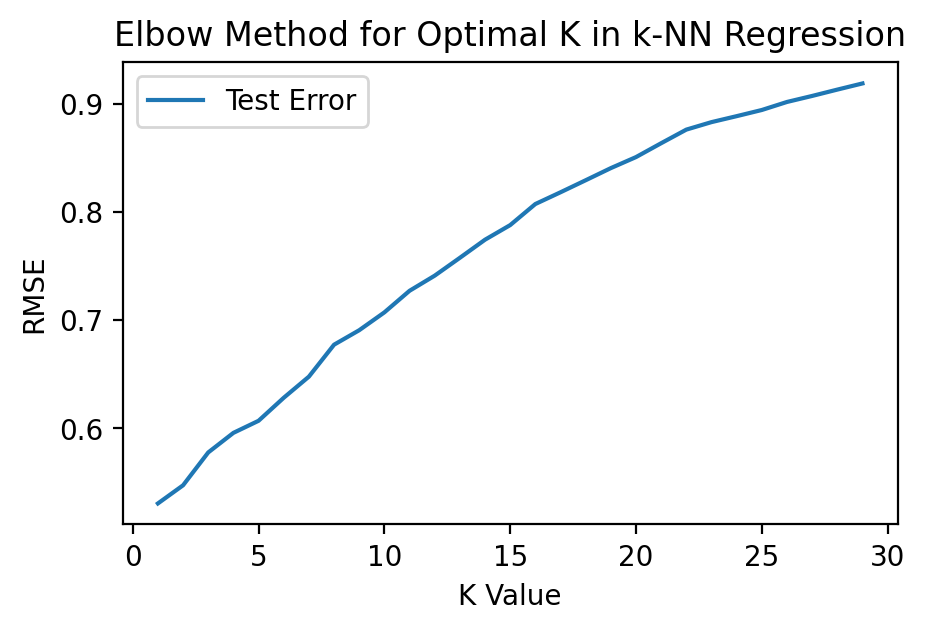

In [24]:
X = Lisbon_Properties[Lisbon_Properties['N_Rooms'] != -1].drop(['N_Rooms','Title','Total_Area','Type','Typology','Region','extras'], axis=1)
y = Lisbon_Properties[Lisbon_Properties['N_Rooms'] != -1]['N_Rooms']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

test_errors = []
k_errors = []

for k in range(1,30):
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred = knn_model.predict(scaled_X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    test_errors.append(rmse)
    k_errors.append([k,rmse])

plt.figure(figsize=(5, 3), dpi=200)
plt.plot(range(1, 30), test_errors, label='Test Error')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('K Value')
plt.title('Elbow Method for Optimal K in k-NN Regression')
plt.show()

In [25]:
k_errors[0:5]

[[1, 0.5307106054810153],
 [2, 0.5474866227289791],
 [3, 0.5778473422642131],
 [4, 0.59593259594918],
 [5, 0.6071069192238786]]

<h3 style="font-size: 20px; color: #5e6670;"><strong>K = 1</strong></h3>

In [26]:
knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(scaled_X_train,y_train) 

y_preds = knn_model.predict(scaled_X_test)

In [27]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_preds
})

results_df['Predicted'] = results_df['Predicted'].apply(lambda x: round(x))
results_df['Accuracy'] = results_df.apply(lambda row: 1 if row['Actual'] == row['Predicted'] else 0, axis=1)
len(results_df[results_df['Accuracy'] == 1]) / len(results_df) * 100

78.81136950904393

<h3 style="font-size: 20px; color: #5e6670;"><strong>K = 2</strong></h3>

In [28]:
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(scaled_X_train,y_train) 

y_preds = knn_model.predict(scaled_X_test)

In [29]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_preds
})

results_df['Predicted'] = results_df['Predicted'].apply(lambda x: round(x))
results_df['Accuracy'] = results_df.apply(lambda row: 1 if row['Actual'] == row['Predicted'] else 0, axis=1)
len(results_df[results_df['Accuracy'] == 1]) / len(results_df) * 100

74.4186046511628

<span style="font-size: 15px; color: #5e6670;"><strong>Since we have higher accuracy for K = 1, we decided to use K = 1</strong></span> 

<span style="font-size: 15px; color: #5e6670;"><strong>First, we need to identify the indices that we need to fill (where N_Rooms = -1) and then we will scale the data and make our predictions for these rows</strong></span> 

In [30]:
unknown_rooms_index = Lisbon_Properties[Lisbon_Properties['N_Rooms'] == -1].index
scaled_unknown_rooms = scaler.transform(Lisbon_Properties.loc[unknown_rooms_index].drop(['N_Rooms','Title','Total_Area','Type','Typology','Region','extras'], axis=1))

predictions = []
for room in scaled_unknown_rooms:
    room = room.reshape(1, -1)
    prediction = knn_model.predict(room)
    predictions.append(prediction[0])

<span style="font-size: 15px; color: #5e6670;"><strong>Confirmation of the rows</strong></span> 

In [31]:
Lisbon_Properties.loc[unknown_rooms_index]

,id,Title,Price,N_Rooms,Total_Area,Latitude,Longitude,Region,extras,Type,Typology,Extra_Rooms,Extra_Rooms_Flag,Total_N_Rooms,Area_m2,N_Extras,Extras_Flag
438,473,"Apartamento na Rua Castelo Branco Saraiva, Pen...",224000,-1,Área bruta 72 m²,38.725770,-9.126800,Penha_de_França,,Apartamento,na,0,0,-1,72,0,0
595,643,"Loft em Largo de Andaluz, Santo António, Lisboa",850000,-1,Área bruta 159 m²,38.727636,-9.147746,Santo_António,Com elevador,Loft,em,0,0,-1,159,1,1
600,648,"Apartamento na Rua do Vale de Santo António, S...",299900,-1,Área bruta 63 m²,38.717810,-9.122470,São_Vicente,Rés do chão,Apartamento,na,0,0,-1,63,1,1
702,753,"Apartamento em Penha de França, Lisboa",224000,-1,Área bruta 70 m²,38.725440,-9.127490,Penha_de_França,,Apartamento,em,0,0,-1,70,0,0
703,754,"Apartamento na Rua Francisco Pereira de Sousa,...",980000,-1,Área bruta 320 m²,38.744450,-9.178450,São_Domingos_de_Benfica,,Apartamento,na,0,0,-1,320,0,0
758,812,"Apartamento em São Vicente, Lisboa",299000,-1,Área bruta 36 m²,38.716810,-9.121540,São_Vicente,,Apartamento,em,0,0,-1,36,0,0
872,940,"Loft em Campolide, Lisboa",690000,-1,Área bruta 502 m²,38.720200,-9.171478,Campolide,,Loft,em,0,0,-1,502,0,0
892,960,"Apartamento na Rua do Vale de Santo António, S...",399900,-1,Área bruta 60 m²,38.717792,-9.122492,São_Vicente,,Apartamento,na,0,0,-1,60,0,0
915,983,"Apartamento na Rua do Vale de Santo António, S...",299900,-1,Área bruta 63 m²,38.717802,-9.122512,São_Vicente,Rés do chão,Apartamento,na,0,0,-1,63,1,1
930,998,"Estúdio em São Vicente, Lisboa",190000,-1,Área bruta 25 m²,38.714350,-9.128380,São_Vicente,,Estúdio,em,0,0,-1,25,0,0


<span style="font-size: 15px; color: #5e6670;"><strong>Assign our predictions to each row</strong></span> 

In [32]:
Lisbon_Properties.loc[unknown_rooms_index, 'N_Rooms'] = predictions

In [33]:
Lisbon_Properties.loc[unknown_rooms_index]

,id,Title,Price,N_Rooms,Total_Area,Latitude,Longitude,Region,extras,Type,Typology,Extra_Rooms,Extra_Rooms_Flag,Total_N_Rooms,Area_m2,N_Extras,Extras_Flag
438,473,"Apartamento na Rua Castelo Branco Saraiva, Pen...",224000,1.0,Área bruta 72 m²,38.725770,-9.126800,Penha_de_França,,Apartamento,na,0,0,-1,72,0,0
595,643,"Loft em Largo de Andaluz, Santo António, Lisboa",850000,1.0,Área bruta 159 m²,38.727636,-9.147746,Santo_António,Com elevador,Loft,em,0,0,-1,159,1,1
600,648,"Apartamento na Rua do Vale de Santo António, S...",299900,0.5,Área bruta 63 m²,38.717810,-9.122470,São_Vicente,Rés do chão,Apartamento,na,0,0,-1,63,1,1
702,753,"Apartamento em Penha de França, Lisboa",224000,1.0,Área bruta 70 m²,38.725440,-9.127490,Penha_de_França,,Apartamento,em,0,0,-1,70,0,0
703,754,"Apartamento na Rua Francisco Pereira de Sousa,...",980000,1.0,Área bruta 320 m²,38.744450,-9.178450,São_Domingos_de_Benfica,,Apartamento,na,0,0,-1,320,0,0
758,812,"Apartamento em São Vicente, Lisboa",299000,1.0,Área bruta 36 m²,38.716810,-9.121540,São_Vicente,,Apartamento,em,0,0,-1,36,0,0
872,940,"Loft em Campolide, Lisboa",690000,1.5,Área bruta 502 m²,38.720200,-9.171478,Campolide,,Loft,em,0,0,-1,502,0,0
892,960,"Apartamento na Rua do Vale de Santo António, S...",399900,1.0,Área bruta 60 m²,38.717792,-9.122492,São_Vicente,,Apartamento,na,0,0,-1,60,0,0
915,983,"Apartamento na Rua do Vale de Santo António, S...",299900,0.0,Área bruta 63 m²,38.717802,-9.122512,São_Vicente,Rés do chão,Apartamento,na,0,0,-1,63,1,1
930,998,"Estúdio em São Vicente, Lisboa",190000,0.5,Área bruta 25 m²,38.714350,-9.128380,São_Vicente,,Estúdio,em,0,0,-1,25,0,0


<span style="font-size: 15px; color: #5e6670;"><strong>Now we need to make some modifications:</strong></span> 

1. Update N_Rooms to integer
2. Run again the code to calculate the total number of rooms (Total_N_Rooms)
3. Update Typology column

In [34]:
Lisbon_Properties['N_Rooms'] = Lisbon_Properties['N_Rooms'].apply(lambda x: int(x))
Lisbon_Properties['Total_N_Rooms'] = Lisbon_Properties['N_Rooms'] + Lisbon_Properties['Extra_Rooms']
Lisbon_Properties.loc[unknown_rooms_index, 'Typology'] = 'T' + Lisbon_Properties['N_Rooms'].apply(lambda x: str(x))

In [35]:
Lisbon_Properties.loc[unknown_rooms_index]

,id,Title,Price,N_Rooms,Total_Area,Latitude,Longitude,Region,extras,Type,Typology,Extra_Rooms,Extra_Rooms_Flag,Total_N_Rooms,Area_m2,N_Extras,Extras_Flag
438,473,"Apartamento na Rua Castelo Branco Saraiva, Pen...",224000,1,Área bruta 72 m²,38.725770,-9.126800,Penha_de_França,,Apartamento,T1,0,0,1,72,0,0
595,643,"Loft em Largo de Andaluz, Santo António, Lisboa",850000,1,Área bruta 159 m²,38.727636,-9.147746,Santo_António,Com elevador,Loft,T1,0,0,1,159,1,1
600,648,"Apartamento na Rua do Vale de Santo António, S...",299900,0,Área bruta 63 m²,38.717810,-9.122470,São_Vicente,Rés do chão,Apartamento,T0,0,0,0,63,1,1
702,753,"Apartamento em Penha de França, Lisboa",224000,1,Área bruta 70 m²,38.725440,-9.127490,Penha_de_França,,Apartamento,T1,0,0,1,70,0,0
703,754,"Apartamento na Rua Francisco Pereira de Sousa,...",980000,1,Área bruta 320 m²,38.744450,-9.178450,São_Domingos_de_Benfica,,Apartamento,T1,0,0,1,320,0,0
758,812,"Apartamento em São Vicente, Lisboa",299000,1,Área bruta 36 m²,38.716810,-9.121540,São_Vicente,,Apartamento,T1,0,0,1,36,0,0
872,940,"Loft em Campolide, Lisboa",690000,1,Área bruta 502 m²,38.720200,-9.171478,Campolide,,Loft,T1,0,0,1,502,0,0
892,960,"Apartamento na Rua do Vale de Santo António, S...",399900,1,Área bruta 60 m²,38.717792,-9.122492,São_Vicente,,Apartamento,T1,0,0,1,60,0,0
915,983,"Apartamento na Rua do Vale de Santo António, S...",299900,0,Área bruta 63 m²,38.717802,-9.122512,São_Vicente,Rés do chão,Apartamento,T0,0,0,0,63,1,1
930,998,"Estúdio em São Vicente, Lisboa",190000,0,Área bruta 25 m²,38.714350,-9.128380,São_Vicente,,Estúdio,T0,0,0,0,25,0,0


<h3 style="font-size: 20px; color: #5e6670;"><strong>2.1.7. Finding the unique extras to create dummy variables for it</strong></h3>

In [36]:
extras_df = Lisbon_Properties['extras'].str.split(',', expand=True)

extras = []
unique_extras = []

for x in [0,1,2,3,4]:
    extras.append(list(extras_df[x].unique()))

for ext in extras:
    unique_extras += ext

unique_extras = set(unique_extras)
unique_extras = {extra.strip().replace(' ','_') for extra in unique_extras if extra is not None and extra.strip()}

In [37]:
unique_extras

{'Com_elevador',
 'Com_garagem',
 'De_luxo',
 'Piscina',
 'Rés_do_chão',
 'Vista_para_mar',
 'Último_andar'}

In [38]:
for feature in unique_extras:
    Lisbon_Properties[feature] = Lisbon_Properties['extras'].apply(lambda x: int(feature in x))

<span style="font-size: 15px; color: #5e6670;"><strong>Finding the unique extras to create dummy variables for it</strong></span> 

In [39]:
region_dummies = pd.get_dummies(Lisbon_Properties['Region'],dtype=int)
type_dummies = pd.get_dummies(Lisbon_Properties['Type'],dtype=int)

In [40]:
Lisbon_Properties = pd.concat([Lisbon_Properties, region_dummies, type_dummies], axis=1)

<span style="font-size: 15px; color: #5e6670;"><strong>Now we need to make some modifications:</strong></span> 

<span style="font-size: 15px; color: #5e6670;"><strong>Creating dummy variables for Region and Property Type</strong></span> 

In [41]:
region_dummies = pd.get_dummies(Lisbon_Properties['Region'],dtype=int)
type_dummies = pd.get_dummies(Lisbon_Properties['Type'],dtype=int)

In [42]:
Lisbon_Properties = pd.concat([Lisbon_Properties, region_dummies, type_dummies], axis=1)

<span style="font-size: 15px; color: #5e6670;"><strong>Drop Columns that we no longer need</strong></span> 

In [43]:
# columns_to_drop = ['Title', 'Total_Area', 'Latitude', 'Longitude', 'Typology','extras','Region','Type']
# Lisbon_Properties = Lisbon_Properties.drop(columns_to_drop, axis=1)

In [44]:
Lisbon_Properties.head()

,id,Title,Price,N_Rooms,Total_Area,Latitude,Longitude,Region,extras,Type,...,Apartamento,Casa,Duplex,Estúdio,Flat,Loft,Moradia,Palacete,Penthouse,Quinta
0,0,"Apartamento T2 em Alvalade, Lisboa",430000,2,Área bruta 90 m²,38.745739,-9.14259,Alvalade,,Apartamento,...,1,0,0,0,0,0,0,0,0,0
1,1,"Apartamento T1 em Benfica, Lisboa",269900,1,Área bruta 97 m²,38.751710,-9.20090,Benfica,,Apartamento,...,1,0,0,0,0,0,0,0,0,0
2,2,"Apartamento T3 na Rua António Nobre, São Domin...",399900,3,Área bruta 120 m²,38.746570,-9.17989,São_Domingos_de_Benfica,,Apartamento,...,1,0,0,0,0,0,0,0,0,0
3,3,"Apartamento T2 na Rua de São Pedro Mártir, San...",285000,2,Área bruta 55 m²,38.714710,-9.13582,Santa_Maria_Maior,,Apartamento,...,1,0,0,0,0,0,0,0,0,0
4,4,"Apartamento T1 em Praça de Luís de Camões, Mis...",690000,1,Área bruta 93 m²,38.710780,-9.14385,Misericórdia,Com garagem,Apartamento,...,1,0,0,0,0,0,0,0,0,0


In [45]:
Lisbon_Properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1312 entries, 0 to 1330
Data columns (total 92 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1312 non-null   int64  
 1   Title                    1312 non-null   object 
 2   Price                    1312 non-null   int64  
 3   N_Rooms                  1312 non-null   int64  
 4   Total_Area               1312 non-null   object 
 5   Latitude                 1312 non-null   float64
 6   Longitude                1312 non-null   float64
 7   Region                   1312 non-null   object 
 8   extras                   1312 non-null   object 
 9   Type                     1312 non-null   object 
 10  Typology                 1312 non-null   object 
 11  Extra_Rooms              1312 non-null   int64  
 12  Extra_Rooms_Flag         1312 non-null   int64  
 13  Total_N_Rooms            1312 non-null   int64  
 14  Area_m2                  1312

<h1 style="font-size: 30px; color: #5e6670;"><strong>3. Lisbon Metro Info - Wikipedia Webscrapping</strong></h1> 

In [46]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_esta%C3%A7%C3%B5es_do_Metropolitano_de_Lisboa'
response = requests.get(url)
soup = bs4.BeautifulSoup(response.text, 'html.parser')
data = str(soup.find('table', {'class': 'wikitable'}))

table = pd.read_html(data)[0]
columns = ['Nome','Outros nomes','Linha','Lat.','Long.']
Lisbon_Metro = table[columns]

<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [47]:
# Lisbon_Metro.to_csv('Lisbon_Metro.csv')

In [48]:
Lisbon_Metro = pd.read_csv('Lisbon_Metro.csv', index_col=0)
Lisbon_Metro

,Nome,Outros nomes,Linha,Lat.,Long.
0,Aeroporto,—,Vermelha,38.76861,−9.12861
1,Alameda,Alameda I (técn.),Verde,38.73713,−9.13388
2,Alameda,Alameda II (técn.),Vermelha,38.73697,−9.13261
3,Alfornelos,—,Azul,38.76038,−9.20435
4,Alto dos Moinhos,Centro Administrativo (prev.),Azul,38.74994,−9.18003
5,Alvalade,—,Verde,38.75311,−9.14396
6,Amadora Este,Falagueira (prev.),Azul,38.75847,−9.21803
7,Ameixoeira,Carriche (prev.),Amarela,38.77937,−9.15962
8,Anjos,—,Verde,38.72715,−9.13485
9,Areeiro,—,Verde,38.74233,−9.13354


<h2 style="font-size: 25px; color: #5e6670;"><strong>3.1. Lisbon Metro Info - Data Preprocessing</strong></h2> 

<h3 style="font-size: 20px; color: #5e6670;"><strong>3.1.1. Removing last row that contains the same info as the heather of the data frame</strong></h3> 

In [49]:
Lisbon_Metro.drop(index=56, inplace=True)

In [50]:
Lisbon_Metro

,Nome,Outros nomes,Linha,Lat.,Long.
0,Aeroporto,—,Vermelha,38.76861,−9.12861
1,Alameda,Alameda I (técn.),Verde,38.73713,−9.13388
2,Alameda,Alameda II (técn.),Vermelha,38.73697,−9.13261
3,Alfornelos,—,Azul,38.76038,−9.20435
4,Alto dos Moinhos,Centro Administrativo (prev.),Azul,38.74994,−9.18003
5,Alvalade,—,Verde,38.75311,−9.14396
6,Amadora Este,Falagueira (prev.),Azul,38.75847,−9.21803
7,Ameixoeira,Carriche (prev.),Amarela,38.77937,−9.15962
8,Anjos,—,Verde,38.72715,−9.13485
9,Areeiro,—,Verde,38.74233,−9.13354


<h3 style="font-size: 20px; color: #5e6670;"><strong>3.1.2. Creating a new column - Nome_Concat (Concats the name and the sub-name, aka 'Outros nomes', of each Lisbon Metro Station)</strong></h3> 

In [51]:
Lisbon_Metro['Nome_Concat'] = Lisbon_Metro['Nome']+' - '+Lisbon_Metro['Outros nomes']
Lisbon_Metro.head()

,Nome,Outros nomes,Linha,Lat.,Long.,Nome_Concat
0,Aeroporto,—,Vermelha,38.76861,−9.12861,Aeroporto - —
1,Alameda,Alameda I (técn.),Verde,38.73713,−9.13388,Alameda - Alameda I (técn.)
2,Alameda,Alameda II (técn.),Vermelha,38.73697,−9.13261,Alameda - Alameda II (técn.)
3,Alfornelos,—,Azul,38.76038,−9.20435,Alfornelos - —
4,Alto dos Moinhos,Centro Administrativo (prev.),Azul,38.74994,−9.18003,Alto dos Moinhos - Centro Administrativo (prev.)


In [52]:
Lisbon_Metro['Lat.'] = Lisbon_Metro['Lat.'].apply(lambda x: float(x))
Lisbon_Metro['Long.'] = Lisbon_Metro['Long.'].apply(lambda x: x.replace('−','-'))
Lisbon_Metro['Long.'] = Lisbon_Metro['Long.'].apply(lambda x: float(x))

<span style="font-size: 20px; color: red;"><strong>Note: before we convert 'Long.' to float, we had to replace the symbol '−' by a real minus '-'</strong></span> 

<h1 id = "metro" style="font-size: 30px; color: #5e6670;"><strong>4. Lisbon Cultural Facilities Info - Lisboa Aberta Webscrapping: Create Cultural Score</strong></h1> 

<h2 style="font-size: 25px; color: #5e6670;"><strong>4.1. Museaums Data</strong></h2> 

In [53]:
museums_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POICultura/FeatureServer/3/query?where=1%3D1&outFields=*&f=pgeojson'

response = requests.get(museums_url)
response.raise_for_status()

mdf = gpd.read_file(response.text)

Lisbon_Museums = pd.DataFrame(mdf)
Lisbon_Museums.head()

,OBJECTID,COD_SIG,INF_NOME,INF_MORADA,FREGUESIA,INF_TELEFONE,INF_EMAIL,INF_SITE,INF_DESCRICAO,INF_ACTIVO,GlobalID,geometry
0,1,656,Museu de Arte Popular,Avenida de Brasília,Belém,+ 351 213 011 282,geral@map.dgpc.pt,https://museuartepopular.wordpress.com/,"Inaugurado em 1948, o seu acervo é essencialme...",1,4188e21c-373e-429e-b209-95c8ec28a34c,POINT (-9.20845 38.69380)
1,3,658,Museu Coleção Berardo,Praça do Império\nCentro Cultural de Belém\n\n,Belém,+351 213 612 878,museuberardo@museuberardo.pt,www.museuberardo.pt,O Museu Coleção Berardo abriu portas a 25 de j...,1,e9b18708-da7a-4c91-87b4-dc1a4646a55b,POINT (-9.20773 38.69575)
2,4,659,"MAAT - Museu de Arte, Arquitetura e Tecnologia",Avenida de Brasília,Belém,+351 210 028 130,info.maat@edp.pt,https://www.maat.pt,"O MAAT, propriedade da Fundação EDP, é um espa...",1,d30df7a4-89fd-4570-a5e2-aca9fdff84f8,POINT (-9.19372 38.69604)
3,5,660,Museu Nacional dos Coches,Avenida da Índia,Belém,+ 351 210 732 319,geral@mncoches.dgpc.pt,http://museudoscoches.gov.pt/pt/,"O atual edifício do Museu dos Coches, desenhad...",1,be5d44a3-dd01-4258-a3ae-c3b73e74e446,POINT (-9.19839 38.69680)
4,6,661,Museu de Marinha,Praça do Império \nMosteiro dos Jerónimos,Belém,+351 210 977 988,geral.museu@marinha.pt,http://ccm.marinha.pt/pt/museu,"Organizado em zonas temáticas distintas, poder...",1,658ca5c9-bc5b-49c7-ba5b-18659c32036b,POINT (-9.20924 38.69723)


<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [54]:
# Lisbon_Museums = Lisbon_Museums.to_csv('Lisbon_Museums.csv')

In [55]:
Lisbon_Museums = pd.read_csv('Lisbon_Museums.csv', index_col=0)

<h2 style="font-size: 25px; color: #5e6670;"><strong>4.2. Theaters Data</strong></h2> 

In [56]:
theaters_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POICultura/FeatureServer/4/query?where=1%3D1&outFields=*&f=pgeojson'

response = requests.get(theaters_url)
response.raise_for_status()

tdf = gpd.read_file(response.text)

Lisbon_Theaters = pd.DataFrame(tdf)
Lisbon_Theaters.head()

,OBJECTID,COD_SIG,INF_NOME,INF_MORADA,FREGUESIA,INF_TELEFONE,INF_EMAIL,INF_SITE,INF_DESCRICAO,INF_ACTIVO,GlobalID,geometry
0,1,758,Gabinete curiosidades Karnart,"Avenida da Índia, 168",Belém,+351 213 466 411/+351 914 150 935,geral@karnart.org,www.karnart.org,O Gabinete Curiosidades Karnart é a sede da KA...,1,3fe9f7da-7fad-4b14-acb3-52f2e9c0c4a6,POINT (-9.21166 38.69427)
1,2,759,Academia Dramática Familiar 1º de Novembro,"Rua da Praia de Pedrouços, 76-78",Belém,+351 213 012 601,None,None,Edifício do séc XIX de arquitectura cultural e...,1,54f50c25-86c4-4cfa-afda-56bc0df13bde,POINT (-9.21781 38.69461)
2,5,762,LU.CA - Teatro Luís de Camões,"Calçada da Ajuda, 80",Belém,+351 215 939 100,info@lucateatroluisdecamoes.pt,www.lucateatroluisdecamoes.pt,"Pequeno teatro de gosto neoclássico tardio, in...",1,bfdcb6c3-99a0-4295-a270-91707f347131,POINT (-9.19938 38.69903)
3,6,763,Espaço POGO,"Rua da Cintura do Porto de Lisboa, Edifício 403",Estrela,+351 916 403 994,info@pogo.pt,http://www.pogo.pt,None,1,51727d32-af42-4cae-bc34-9628b47b8d51,POINT (-9.15388 38.70570)
4,7,764,Teatro Cinearte,"Largo de Santos, 2-2E",Estrela,21 396 53 60/275,barraca@mail.telepac.pt / bilheteira@abarraca.com,www.abarraca.com,Encomendado pela Sociedade Administradora de C...,1,70165c4b-3536-4eb2-83bd-36d07a1110e8,POINT (-9.15524 38.70718)


<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [57]:
# Lisbon_Theaters.to_csv('Lisbon_Theaters.csv')

In [58]:
Lisbon_Theaters = pd.read_csv('Lisbon_Theaters.csv', index_col=0)

<h2 style="font-size: 25px; color: #5e6670;"><strong>4.3. Cinemas Data</strong></h2> 

In [59]:
cin_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POICultura/FeatureServer/2/query?where=1%3D1&outFields=*&f=pgeojson'

response = requests.get(cin_url)
response.raise_for_status() 

cdf = gpd.read_file(response.text)

Lisbon_Cinemas = pd.DataFrame(cdf)
Lisbon_Cinemas.head()

,OBJECTID,COD_SIG,INF_NOME,INF_MORADA,FREGUESIA,INF_TELEFONE,INF_EMAIL,INF_SITE,INF_DESCRICAO,INF_FONTE,INF_ACTIVO,GlobalID,geometry
0,1,506,Cinema Ideal,"Rua do Loreto, 15",Misericórdia,+351 210 998 295,cinemaideal@cinemaideal.pt,www.cinemaideal.pt,"Esta sala de cinema, aberta desde 1904, conhec...",-,1,45afe625-02d7-4712-b6b8-7aa0c2116ed6,POINT (-9.14422 38.71054)
1,2,507,Cinemateca Júnior,"Praça dos Restauradores, Palácio da Foz",Santa Maria Maior,+351 213 462 157 | +351 213 476 129,cinemateca.junior@cinemateca.pt,http://www.cinemateca.pt/,"A Cinemateca Júnior, instalada no Palácio Foz,...",http://www.cinemateca.pt/,1,1d3ca135-5a24-478c-95f4-dd2dc87a65c9,POINT (-9.14217 38.71556)
2,3,508,Cinema São Jorge,"Avenida da Liberdade, 175",Santo António,+351 213 103 400,cinemasaojorge@egeac.pt,http://cinemasaojorge.pt/,"Um dos mais emblemáticos cinemas de Lisboa, co...",http://cinemasaojorge.pt/,1,1bf79faf-5d97-48b3-b085-fa4446c435a2,POINT (-9.14633 38.72029)
3,4,509,Cinemateca Portuguesa,"Rua Barata Salgueiro, 39 R/C",Santo António,+ 351 213 596 200,cinemateca@cinemateca.pt,www.cinemateca.pt/,"Em 1948 foi criada a Cinemateca Nacional, hoje...",-,1,3414bf94-62ac-43c7-a846-0d5e41251e89,POINT (-9.14875 38.72088)
4,5,510,NOS Amoreiras,Avenida Engenheiro Duarte Pacheco Lote 7 2º Lo...,Campo de Ourique,16996,cinema.amoreiras@nos.pt,http://cinemas.nos.pt/,Possui 7 salas\n,http://cinemas.nos.pt/,1,1af99162-1626-4f83-9342-f891e2b442bc,POINT (-9.16210 38.72367)


<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [60]:
# Lisbon_Cinemas.to_csv('Lisbon_Cinemas.csv')

In [61]:
Lisbon_Cinemas = pd.read_csv('Lisbon_Cinemas.csv', index_col=0)

<h2 style="font-size: 25px; color: #5e6670;"><strong>4.4. Auditoriums Data</strong></h2> 

In [62]:
aud_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POICultura/FeatureServer/1/query?where=1%3D1&outFields=*&f=pgeojson'

response = requests.get(aud_url)
response.raise_for_status()

adf = gpd.read_file(response.text)

Lisbon_Auditoriums = pd.DataFrame(adf)
Lisbon_Auditoriums.head()

,OBJECTID,COD_SIG,INF_NOME,INF_MORADA,FREGUESIA,INF_TELEFONE,INF_EMAIL,INF_SITE,INF_DESCRICAO,INF_FONTE,INF_ACTIVO,GlobalID,geometry
0,1,168,Centro de Documentação da Casa da América Latina,"Avenida da Índia, 110",Belém,+351 218 172 490,geral@casamericalatina.pt,http://casamericalatina.pt/inicio/,None,-,1,3d123d45-0d43-4507-b6b3-37a4f384a251,POINT (-9.19434 38.69672)
1,2,169,UCCLA - Centro de Documentação,"Avenida da Índia, 110",Belém,+351 218 172 950,uccla@uccla.pt,http://www.uccla.pt/,A UCCLA é uma associação intermunicipal de nat...,-,1,d3cc88bf-d350-4f9d-829a-94cd08ffebb8,POINT (-9.19434 38.69675)
2,3,170,Biblioteca de Belém,Rua da Junqueira 295,Belém,+351 218 172 580,bib.belem@cm-lisboa.pt,http://blx.cm-lisboa.pt,A Biblioteca Municipal de Belém encontra-se in...,CML - Rede BLx,1,53473127-6007-4d47-9b87-fa4e563c56f8,POINT (-9.19584 38.69713)
3,4,171,Arquivo Central e Arquivo Histórico de Marinha,Avenida da Índia S/N 1º,Belém,21 362 76 00,arquivo.central@marinha.pt / arquivo.historico...,www.marinha.pt,Fundos com origem na documentação da antiga Se...,www.marinha.pt,1,ae67622f-e6cc-4a72-afd3-f69f2d4039cb,POINT (-9.19237 38.69717)
4,5,172,Biblioteca Central da Marinha,Praça do Império Museu da Marinha R/C,Belém,21 365 85 20,biblioteca.marinha@marinha.pt,www.marinha.pt,"Situada, desde 1891, na Praça do Império, na i...",www.marinha.pt,1,fd047b92-5e5f-45f4-bf47-c703cfb0012f,POINT (-9.20924 38.69720)


<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [63]:
# Lisbon_Auditoriums.to_csv('Lisbon_Auditoriums.csv')

In [64]:
Lisbon_Auditoriums = pd.read_csv('Lisbon_Auditoriums.csv', index_col=0)

<h2 style="font-size: 25px; color: #5e6670;"><strong>4.5. Creating a static column 'Type' to identify the facilities of each rows (e.g. Museums, Theaters, etc)</strong></h2> 

In [65]:
Lisbon_Museums['Type'] = 'Museum'
Lisbon_Theaters['Type'] = 'Theater'
Lisbon_Cinemas['Type'] = 'Cinema'
Lisbon_Auditoriums['Type'] = 'Auditorium'

<h2 style="font-size: 25px; color: #5e6670;"><strong>4.6. Cultural Dataframe</strong></h2> 

In [66]:
culture_list = [Lisbon_Museums, Lisbon_Theaters, Lisbon_Cinemas, Lisbon_Auditoriums] 
Lisbon_Culture = pd.concat(culture_list)
Lisbon_Culture.head()

,OBJECTID,COD_SIG,INF_NOME,INF_MORADA,FREGUESIA,INF_TELEFONE,INF_EMAIL,INF_SITE,INF_DESCRICAO,INF_ACTIVO,GlobalID,geometry,Type,INF_FONTE
0,1,656,Museu de Arte Popular,Avenida de Brasília,Belém,+ 351 213 011 282,geral@map.dgpc.pt,https://museuartepopular.wordpress.com/,"Inaugurado em 1948, o seu acervo é essencialme...",1,4188e21c-373e-429e-b209-95c8ec28a34c,POINT (-9.20844625414179 38.6938036001826),Museum,NaN
1,3,658,Museu Coleção Berardo,Praça do Império\nCentro Cultural de Belém\n\n,Belém,+351 213 612 878,museuberardo@museuberardo.pt,www.museuberardo.pt,O Museu Coleção Berardo abriu portas a 25 de j...,1,e9b18708-da7a-4c91-87b4-dc1a4646a55b,POINT (-9.20773166084022 38.6957476923844),Museum,NaN
2,4,659,"MAAT - Museu de Arte, Arquitetura e Tecnologia",Avenida de Brasília,Belém,+351 210 028 130,info.maat@edp.pt,https://www.maat.pt,"O MAAT, propriedade da Fundação EDP, é um espa...",1,d30df7a4-89fd-4570-a5e2-aca9fdff84f8,POINT (-9.19371529028373 38.6960435304729),Museum,NaN
3,5,660,Museu Nacional dos Coches,Avenida da Índia,Belém,+ 351 210 732 319,geral@mncoches.dgpc.pt,http://museudoscoches.gov.pt/pt/,"O atual edifício do Museu dos Coches, desenhad...",1,be5d44a3-dd01-4258-a3ae-c3b73e74e446,POINT (-9.19838680167877 38.6968006044798),Museum,NaN
4,6,661,Museu de Marinha,Praça do Império \nMosteiro dos Jerónimos,Belém,+351 210 977 988,geral.museu@marinha.pt,http://ccm.marinha.pt/pt/museu,"Organizado em zonas temáticas distintas, poder...",1,658ca5c9-bc5b-49c7-ba5b-18659c32036b,POINT (-9.20923637432389 38.6972269914078),Museum,NaN


<h3 style="font-size: 20px; color: #5e6670;"><strong>4.6.1. Cultural Dataframe - Data Preprocessing</strong></h3> 

<span style="font-size: 15px; color: #5e6670;"><strong>Transform the 'geometry' column to Shapely Point objects to subsequently extract latitude and longitude</strong></span> 

In [67]:
Lisbon_Culture['geometry'] = Lisbon_Culture['geometry'].apply(wkt.loads)

In [68]:
Lisbon_Culture.dtypes

OBJECTID          int64
COD_SIG           int64
INF_NOME         object
INF_MORADA       object
FREGUESIA        object
INF_TELEFONE     object
INF_EMAIL        object
INF_SITE         object
INF_DESCRICAO    object
INF_ACTIVO        int64
GlobalID         object
geometry         object
Type             object
INF_FONTE        object
dtype: object

<span style="font-size: 15px; color: #5e6670;"><strong>Drop columns that we no longer need</strong></span> 

In [69]:
colms_to_drop = ['COD_SIG', 'INF_MORADA', 'INF_TELEFONE', 'INF_EMAIL', 'INF_SITE', 'INF_DESCRICAO', 'INF_ACTIVO', 'INF_FONTE']
Lisbon_Culture.drop(colms_to_drop, axis=1, inplace=True)

<span style="font-size: 15px; color: #5e6670;"><strong>Checking duplicates</strong></span> 

In [70]:
duplicates = Lisbon_Culture.duplicated()
print("Duplicate rows:")
print(Lisbon_Culture[duplicates])

Duplicate rows:
Empty DataFrame
Columns: [OBJECTID, INF_NOME, FREGUESIA, GlobalID, geometry, Type]
Index: []


In [71]:
duplicates = Lisbon_Culture.duplicated(subset=['GlobalID', 'geometry'])
print("Duplicate rows based on columns 'GlobalID' and 'geometry':")
print(Lisbon_Culture[duplicates])

Duplicate rows based on columns 'GlobalID' and 'geometry':
Empty DataFrame
Columns: [OBJECTID, INF_NOME, FREGUESIA, GlobalID, geometry, Type]
Index: []


There are no duplicates

<span style="font-size: 15px; color: #5e6670;"><strong>Spliting Geometry Into Lat. Long. Coordinates</strong></span> 

In [72]:
def extract_lat_long(point):
    if isinstance(point, Point):
        latitude = point.y
        longitude = point.x
        return pd.Series([latitude, longitude])
    else:
        return pd.Series([None, None])

In [73]:
Lisbon_Culture[['latitude', 'longitude']] = Lisbon_Culture['geometry'].apply(extract_lat_long)

In [74]:
Lisbon_Culture.head()

,OBJECTID,INF_NOME,FREGUESIA,GlobalID,geometry,Type,latitude,longitude
0,1,Museu de Arte Popular,Belém,4188e21c-373e-429e-b209-95c8ec28a34c,POINT (-9.20844625414179 38.6938036001826),Museum,38.693804,-9.208446
1,3,Museu Coleção Berardo,Belém,e9b18708-da7a-4c91-87b4-dc1a4646a55b,POINT (-9.20773166084022 38.6957476923844),Museum,38.695748,-9.207732
2,4,"MAAT - Museu de Arte, Arquitetura e Tecnologia",Belém,d30df7a4-89fd-4570-a5e2-aca9fdff84f8,POINT (-9.19371529028373 38.6960435304729),Museum,38.696044,-9.193715
3,5,Museu Nacional dos Coches,Belém,be5d44a3-dd01-4258-a3ae-c3b73e74e446,POINT (-9.19838680167877 38.6968006044798),Museum,38.696801,-9.198387
4,6,Museu de Marinha,Belém,658ca5c9-bc5b-49c7-ba5b-18659c32036b,POINT (-9.20923637432389 38.6972269914078),Museum,38.697227,-9.209236


<span style="font-size: 15px; color: #5e6670;"><strong>Drop 'geometry' column since it is no longer needed</strong></span> 

In [75]:
Lisbon_Culture.drop('geometry', axis=1, inplace=True)

<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [76]:
# Lisbon_Culture.to_csv('Lisbon_Culture.csv')

<h1 style="font-size: 30px; color: #5e6670;"><strong>5. Lisbon Educational Facilities Info - Lisboa Aberta Webscrapping - Create Educational Facilities Score</strong></h1> 

<h2 style="font-size: 25px; color: #5e6670;"><strong>5.1. Pre-School (Public only)</strong></h2> 

In [77]:
pre_public_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POIEducacao/FeatureServer/9/query?outFields=*&where=1%3D1&f=geojson'

response = requests.get(pre_public_url)
response.raise_for_status()

pre_pub = gpd.read_file(response.text)

Lisbon_PrePublic = pd.DataFrame(pre_pub)

<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [78]:
Lisbon_PrePublic.to_csv('Lisbon_PrePublic.csv')

In [79]:
Lisbon_PrePublic = pd.read_csv('Lisbon_PrePublic.csv', index_col=0)

<span style="font-size: 15px; color: #5e6670;"><strong>Create 'Acess' and 'Stage' columns to identify rows as Pre-School and Public</strong></span>  

In [80]:
Lisbon_PrePublic['Access'] = 'Public'
Lisbon_PrePublic['Stage'] = 'Pre-School'

<span style="font-size: 15px; color: #5e6670;"><strong>Rename Columns to Concat</strong></span>

In [81]:
Lisbon_PrePublic.rename(columns={'INF_NOME': 'Name', 'INF_MORADA': 'Address', 'INF_EMAIL': 'Email', 'INF_SITE': 'Website','INF_ACTIVO':'Flag_is_Active', 'FREGUESIA': 'Area'}, inplace=True)

<span style="font-size: 15px; color: #5e6670;"><strong>Drop useless columns</strong></span>

In [82]:
columns_to_drop = ['OBJECTID', 'COD_SIG', 'Address', 'INF_TELEFONE', 'Email', 'Website', 'Flag_is_Active', 'INF_DESCRICAO', 'INF_ID']
Lisbon_PrePublic.drop(columns_to_drop, axis=1, inplace=True)

<span style="font-size: 15px; color: #5e6670;"><strong>Create new columns order</strong></span>

In [83]:
new_order = ['Name', 'Area', 'GlobalID','geometry', 'Access', 'Stage']
Lisbon_PrePublic = Lisbon_PrePublic[new_order]

Lisbon_PrePublic.head()

,Name,Area,GlobalID,geometry,Access,Stage
0,Escola Profissional Metropolitana de Lisboa,Alcântara,707e37d5-e1b5-45fc-85f8-cc7095308431,POINT (-9.18158997715356 38.699297532228),Public,Pre-School
1,Conservatório Metropolitano de Música de Lisboa,Alcântara,83edfbca-6558-460e-93d1-0475467960a1,POINT (-9.1813018524282 38.6993993202234),Public,Pre-School
2,Academia de Música de Luisboa - Os Violinos,Belém,a421d20f-eb13-4126-a30c-2158b07fe2fd,POINT (-9.1944372593028 38.7001317342682),Public,Pre-School
3,Acordarte - Academia de Música de Lisboa,Belém,24aa8435-1660-4cdd-a993-5113daefd230,POINT (-9.1944372593028 38.7001317342682),Public,Pre-School
4,Escola Profissional de Imagem (ETIC),Misericórdia,049de07d-4405-4a0f-8946-4ddce0c71d28,POINT (-9.14745713248909 38.7078031160822),Public,Pre-School


In [84]:
new_order = ['Name', 'Area', 'GlobalID','geometry', 'Access', 'Stage']
Lisbon_PrePublic = Lisbon_PrePublic[new_order]

Lisbon_PrePublic.head()

,Name,Area,GlobalID,geometry,Access,Stage
0,Escola Profissional Metropolitana de Lisboa,Alcântara,707e37d5-e1b5-45fc-85f8-cc7095308431,POINT (-9.18158997715356 38.699297532228),Public,Pre-School
1,Conservatório Metropolitano de Música de Lisboa,Alcântara,83edfbca-6558-460e-93d1-0475467960a1,POINT (-9.1813018524282 38.6993993202234),Public,Pre-School
2,Academia de Música de Luisboa - Os Violinos,Belém,a421d20f-eb13-4126-a30c-2158b07fe2fd,POINT (-9.1944372593028 38.7001317342682),Public,Pre-School
3,Acordarte - Academia de Música de Lisboa,Belém,24aa8435-1660-4cdd-a993-5113daefd230,POINT (-9.1944372593028 38.7001317342682),Public,Pre-School
4,Escola Profissional de Imagem (ETIC),Misericórdia,049de07d-4405-4a0f-8946-4ddce0c71d28,POINT (-9.14745713248909 38.7078031160822),Public,Pre-School


<h2 style="font-size: 25px; color: #5e6670;"><strong>5.2. 1st Cicle Public/Private</strong></h2>  

In [85]:
# Public Schools
first_public_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POIEducacao/FeatureServer/1/query?outFields=*&where=1%3D1&f=geojson'

response = requests.get(first_public_url)
response.raise_for_status()

Lisbon_1stPublic = gpd.read_file(response.text)
Lisbon_1stPublic = pd.DataFrame(Lisbon_1stPublic)

# Private Schools
first_private_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POIEducacao/FeatureServer/6/query?where=1%3D1&outFields=*&f=pgeojson'

response = requests.get(first_private_url)
response.raise_for_status()

Lisbon_1stPrivate  = gpd.read_file(response.text)
Lisbon_1stPrivate = pd.DataFrame(Lisbon_1stPrivate)

<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [86]:
# Lisbon_1stPublic.to_csv('Lisbon_1stPublic.csv')
# Lisbon_1stPrivate.to_csv('Lisbon_1stPrivate.csv')

In [87]:
Lisbon_1stPublic = pd.read_csv('Lisbon_1stPublic.csv',index_col=0)
Lisbon_1stPrivate = pd.read_csv('Lisbon_1stPrivate.csv',index_col=0)

<span style="font-size: 15px; color: #5e6670;"><strong>Create 'Acess' and 'Stage' columns to identify rows as Pre-School and Public</strong></span>  

In [88]:
Lisbon_1stPublic['Access'] = 'Public'
Lisbon_1stPublic['Stage'] = 'First'
Lisbon_1stPrivate['Access'] = 'Private'
Lisbon_1stPrivate['Stage'] = 'First'

<span style="font-size: 15px; color: #5e6670;"><strong>Rename Columns to Concat</strong></span>

In [89]:
Lisbon_1stPublic.rename(columns={'NOME_ESCOLA': 'Name', 'MORADA': 'Address', 'FREGUESIA12': 'Area'}, inplace=True)
Lisbon_1stPrivate.rename(columns={'INF_NOME': 'Name', 'INF_MORADA': 'Address', 'FREGUESIA': 'Area', 'INF_SITE': 'Website'}, inplace=True)

<span style="font-size: 15px; color: #5e6670;"><strong>Drop useless columns</strong></span>

In [90]:
needed_columns = ['Name', 'Area', 'GlobalID', 'geometry', 'Access', 'Stage']

Lisbon_1stPublic = Lisbon_1stPublic[needed_columns]
Lisbon_1stPrivate = Lisbon_1stPrivate[needed_columns]

<span style="font-size: 15px; color: #5e6670;"><strong>Create new columns order</strong></span>

In [91]:
new_order = ['Name', 'Area', 'GlobalID','geometry', 'Access', 'Stage']

Lisbon_1stPublic = Lisbon_1stPublic[new_order]
Lisbon_1stPrivate = Lisbon_1stPrivate[new_order]

<h2 style="font-size: 25px; color: #5e6670;"><strong>5.3. 2nd/3rd Cicle Public/Private</strong></h2>  

In [92]:
# Public
second_public_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POIEducacao/FeatureServer/1/query?outFields=*&where=1%3D1&f=geojson'

response = requests.get(second_public_url)
response.raise_for_status() 

Lisbon_2ndPublic  = gpd.read_file(response.text)
Lisbon_2ndPublic = pd.DataFrame(Lisbon_2ndPublic)

# Private
second_private_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POIEducacao/FeatureServer/6/query?outFields=*&where=1%3D1&f=geojson'

response = requests.get(second_private_url)
response.raise_for_status() 

Lisbon_2ndPrivate  = gpd.read_file(response.text)
Lisbon_2ndPrivate = pd.DataFrame(Lisbon_2ndPrivate)

<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [93]:
# Lisbon_2ndPublic.to_csv('Lisbon_2ndPublic.csv')
# Lisbon_2ndPrivate.to_csv('Lisbon_2ndPrivate.csv')

In [94]:
Lisbon_2ndPublic = pd.read_csv('Lisbon_2ndPublic.csv', index_col=0)
Lisbon_2ndPrivate = pd.read_csv('Lisbon_2ndPrivate.csv', index_col=0)

<span style="font-size: 15px; color: #5e6670;"><strong>Create 'Acess' and 'Stage' columns to identify rows as Pre-School and Public</strong></span>  

In [95]:
Lisbon_2ndPublic['Access'] = 'Public'
Lisbon_2ndPublic['Stage'] = 'Second'

Lisbon_2ndPrivate['Access'] = 'Private'
Lisbon_2ndPrivate['Stage'] = 'Second'

<span style="font-size: 15px; color: #5e6670;"><strong>Rename Columns to Concat</strong></span>

In [96]:
Lisbon_2ndPublic.rename(columns={'NOME_ESCOLA': 'Name', 'MORADA': 'Address', 'FREGUESIA12': 'Area', 'INF_SITE': 'Website'}, inplace=True)
Lisbon_2ndPrivate.rename(columns={'INF_NOME': 'Name', 'INF_MORADA': 'Address', 'FREGUESIA': 'Area', 'SITE': 'Website'}, inplace=True)

<span style="font-size: 15px; color: #5e6670;"><strong>Drop useless columns</strong></span>

In [97]:
needed_columns = ['Name', 'Area', 'GlobalID', 'geometry', 'Access', 'Stage']

Lisbon_2ndPublic = Lisbon_1stPublic[needed_columns]
Lisbon_2ndPrivate = Lisbon_1stPrivate[needed_columns]

<span style="font-size: 15px; color: #5e6670;"><strong>Create new columns order</strong></span>

In [98]:
new_order = ['Name', 'Area', 'GlobalID','geometry', 'Access', 'Stage']

Lisbon_2ndPublic = Lisbon_2ndPublic[new_order]
Lisbon_2ndPrivate = Lisbon_2ndPrivate[new_order]

<h2 style="font-size: 25px; color: #5e6670;"><strong>5.4. High School Public/Private</strong></h2>   

In [99]:
# Public
high_public_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POIEducacao/FeatureServer/1/query?outFields=*&where=1%3D1&f=geojson'

response = requests.get(high_public_url)
response.raise_for_status()

Lisbon_HSchool_Public = gpd.read_file(response.text)
Lisbon_HSchool_Public = pd.DataFrame(Lisbon_HSchool_Public)

#Private
high_private_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POIEducacao/FeatureServer/7/query?outFields=*&where=1%3D1&f=geojson'

response = requests.get(high_private_url)
response.raise_for_status()

Lisbon_HSchool_Private  = gpd.read_file(response.text)
Lisbon_HSchool_Private = pd.DataFrame(Lisbon_HSchool_Private)

<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [100]:
Lisbon_HSchool_Public.to_csv('Lisbon_HSchool_Public.csv')
Lisbon_HSchool_Private.to_csv('Lisbon_HSchool_Private.csv')

<span style="font-size: 15px; color: #5e6670;"><strong>Create 'Acess' and 'Stage' columns to identify rows as Pre-School and Public</strong></span>  

In [101]:
Lisbon_HSchool_Public['Access'] = 'Public'
Lisbon_HSchool_Public['Stage'] = 'Second'

Lisbon_HSchool_Private['Access'] = 'Private'
Lisbon_HSchool_Private['Stage'] = 'HighSchool'

<span style="font-size: 15px; color: #5e6670;"><strong>Rename Columns to Concat</strong></span>

In [102]:
Lisbon_HSchool_Public.rename(columns={'INF_NOME': 'Name', 'INF_MORADA': 'Address', 'FREGUESIA': 'Area', 'INF_SITE': 'Website'}, inplace=True)
Lisbon_HSchool_Private.rename(columns={'INF_NOME': 'Name', 'INF_MORADA': 'Address', 'FREGUESIA': 'Area', 'INF_SITE': 'Website'}, inplace=True)

<span style="font-size: 15px; color: #5e6670;"><strong>Drop useless columns</strong></span>

In [103]:
needed_columns = ['Name', 'Area', 'GlobalID', 'geometry', 'Access', 'Stage']

Lisbon_HSchool_Public = Lisbon_1stPublic[needed_columns]
Lisbon_HSchool_Private = Lisbon_1stPrivate[needed_columns]

<span style="font-size: 15px; color: #5e6670;"><strong>Create new columns order</strong></span>

In [104]:
new_order = ['Name', 'Area', 'GlobalID','geometry', 'Access', 'Stage']
Lisbon_HSchool_Public = Lisbon_HSchool_Public[new_order]
Lisbon_HSchool_Private = Lisbon_HSchool_Private[new_order]

<h2 style="font-size: 25px; color: #5e6670;"><strong>5.5. College Public/Private</strong></h2>   

In [105]:
uni_url = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/MapaConhecimento/FeatureServer/1/query?where=1%3D1&outFields=*&f=pgeojson'

response = requests.get(uni_url)
response.raise_for_status() 

uni_all  = response.json()

Lisbon_AllUni = gpd.GeoDataFrame.from_features(uni_all['features'])

Lisbon_AllUni = pd.DataFrame(Lisbon_AllUni)

<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [106]:
# Lisbon_AllUni.to_csv('Lisbon_AllUni.csv')

In [107]:
Lisbon_AllUni = pd.read_csv('Lisbon_AllUni.csv', index_col=0)

<span style="font-size: 15px; color: #5e6670;"><strong>Create 'Acess' and 'Stage' columns to identify rows as Pre-School and Public</strong></span>  

In [108]:
Lisbon_AllUni['Access'] = 'All'
Lisbon_AllUni['Stage'] = 'Uni'

<span style="font-size: 15px; color: #5e6670;"><strong>Rename Columns to Concat</strong></span>

In [109]:
Lisbon_AllUni.rename(columns={'NOME': 'Name', 'MORADA': 'Address', 'SITE': 'Website'}, inplace=True)
Lisbon_AllUni['Area'] = 'NaN'

<span style="font-size: 15px; color: #5e6670;"><strong>Drop useless columns</strong></span>

In [110]:
columns_to_drop_uni = ['OBJECTID', 'COD_SIG', 'IDTIPO', 'Address', 'ATORTIPOCODIGO', 'EMAIL', 'Website', 'REDESOCIAL', 'REDESOCIAL']
Lisbon_AllUni.drop(columns_to_drop_uni, axis=1, inplace=True)

<span style="font-size: 15px; color: #5e6670;"><strong>Create new columns order</strong></span>

In [111]:
needed_columns = ['Name', 'Area', 'GlobalID', 'geometry', 'Access', 'Stage']
Lisbon_AllUni = Lisbon_AllUni[new_order]

<h2 style="font-size: 25px; color: #5e6670;"><strong>5.6. Educational Dataframe</strong></h2>   

<span style="font-size: 15px; color: #5e6670;"><strong>Check Common Columns for Concat</strong></span>

In [112]:
edu_list = [Lisbon_PrePublic, Lisbon_1stPrivate, Lisbon_1stPublic, Lisbon_2ndPrivate, Lisbon_2ndPublic, Lisbon_HSchool_Public, Lisbon_HSchool_Private, Lisbon_AllUni]

common_columns = set(edu_list[0].columns)
for df in edu_list[1:]:
    common_columns.intersection_update(df.columns)

print(f"Common columns: {common_columns}")

Common columns: {'Name', 'Area', 'Stage', 'Access', 'geometry', 'GlobalID'}


<span style="font-size: 15px; color: #5e6670;"><strong>Concat Dataframes</strong></span>

In [113]:
Lisbon_Education = pd.concat(edu_list)
Lisbon_Education

,Name,Area,GlobalID,geometry,Access,Stage
0,Escola Profissional Metropolitana de Lisboa,Alcântara,707e37d5-e1b5-45fc-85f8-cc7095308431,POINT (-9.18158997715356 38.699297532228),Public,Pre-School
1,Conservatório Metropolitano de Música de Lisboa,Alcântara,83edfbca-6558-460e-93d1-0475467960a1,POINT (-9.1813018524282 38.6993993202234),Public,Pre-School
2,Academia de Música de Luisboa - Os Violinos,Belém,a421d20f-eb13-4126-a30c-2158b07fe2fd,POINT (-9.1944372593028 38.7001317342682),Public,Pre-School
3,Acordarte - Academia de Música de Lisboa,Belém,24aa8435-1660-4cdd-a993-5113daefd230,POINT (-9.1944372593028 38.7001317342682),Public,Pre-School
4,Escola Profissional de Imagem (ETIC),Misericórdia,049de07d-4405-4a0f-8946-4ddce0c71d28,POINT (-9.14745713248909 38.7078031160822),Public,Pre-School
...,...,...,...,...,...,...
80,ue | Universidade Europeia - FCSD (Faculdade d...,NaN,bd396f8b-c726-4df0-aa96-b6714df4c562,POINT (-9.18365790945365 38.7650161641021),All,Uni
81,ue | Universidade Europeia - FCES (Faculdade d...,NaN,fd0bce17-613a-4c5a-96a6-b55b17478aa9,POINT (-9.19368269569772 38.7600490654187),All,Uni
82,UNL | NOVA IMS - NOVA Information Management S...,NaN,4515c8c1-81ec-4ba6-be95-79b575a776c7,POINT (-9.16030254570311 38.7325791296909),All,Uni
83,UNL | ITQB NOVA - Instituto de Tecnologia Quím...,NaN,23ef0db1-af6f-4549-a281-1e9196115849,POINT (-9.32163033090969 38.6959016232198),All,Uni


<span style="font-size: 20px; color: red;"><strong>Save a backup</strong></span> 

In [114]:
# Lisbon_Education.to_csv('Lisbon_Education.csv')

In [115]:
Lisbon_Education = pd.read_csv('Lisbon_Education.csv', index_col=0)

<h3 style="font-size: 25px; color: #5e6670;"><strong>5.6.1. Educational Dataframe - Data Preprocessing</strong></h3>   

<span style="font-size: 15px; color: #5e6670;"><strong>Check Duplicates</strong></span>

In [116]:
duplicates = Lisbon_Education.duplicated(subset=['GlobalID', 'geometry'])
print("Duplicate rows based on columns 'GlobalID' and 'geometry':")
print(Lisbon_Education[duplicates])

Duplicate rows based on columns 'GlobalID' and 'geometry':
                                Name                     Area  \
0             Colégio do Bom Sucesso                    Belém   
1            Externato Alfredo Binet                    Belém   
2              Cooperativa "A Torre"                    Belém   
3            Externato "A Escolinha"                    Belém   
4   Externato "Santa Maria de Belém"                    Belém   
..                               ...                      ...   
94                 Colégio Place4all         Campo de Ourique   
95           Escola Casa da Floresta  São Domingos de Benfica   
96              Colégio "O Pelicano"                  Areeiro   
97                   Colégio Oriente        Parque das Nações   
98           Externato Alfredo Binet                    Belém   

                                GlobalID  \
0   15cf71ac-1d1e-46d7-a0e7-7f09140d06c2   
1   d693914b-1dc3-42a8-9a06-379bfaf954e2   
2   91d9dfd8-af85-4f8e-a585-

<span style="font-size: 15px; color: #5e6670;"><strong>Drop duplicates</strong></span>

In [117]:
Lisbon_Education = Lisbon_Education.drop_duplicates(subset=['GlobalID', 'geometry'])

<span style="font-size: 15px; color: #5e6670;"><strong>Check nulls</strong></span>

In [118]:
Lisbon_Education['geometry'].isnull().sum()

2

<span style="font-size: 15px; color: #5e6670;"><strong>Drop nulls</strong></span> 

In [119]:
Lisbon_Education = Lisbon_Education.dropna(subset=['geometry']).reset_index(drop=True)

In [120]:
Lisbon_Education['geometry'].isnull().sum()

0

<span style="font-size: 15px; color: #5e6670;"><strong>Transform the 'geometry' column to Shapely Point objects to subsequently extract latitude and longitude</strong></span> 

In [121]:
Lisbon_Education['geometry'] = Lisbon_Education['geometry'].apply(wkt.loads)

In [122]:
Lisbon_Education[['latitude', 'longitude']] = Lisbon_Education['geometry'].apply(extract_lat_long)

In [123]:
Lisbon_Education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       300 non-null    object 
 1   Area       215 non-null    object 
 2   GlobalID   300 non-null    object 
 3   geometry   300 non-null    object 
 4   Access     300 non-null    object 
 5   Stage      300 non-null    object 
 6   latitude   300 non-null    float64
 7   longitude  300 non-null    float64
dtypes: float64(2), object(6)
memory usage: 18.9+ KB


<span style="font-size: 15px; color: #5e6670;"><strong>Calculate distances with latitude and longitude features</strong></span>  

In [124]:
def haversine(lat1, lon1, lat2, lon2):
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    R = 6371.0
    distance = R * c
    
    return distance

<span style="font-size: 15px; color: #5e6670;"><strong>We decided to define a threshold of 0.5 km</strong></span>  

In [125]:
dist_threshold = 0.5

<span style="font-size: 15px; color: #5e6670;"><strong>Calculate Distances between each Property and each Metro Station and add them to Lisbon_Properties Dataframe</strong></span>   

In [126]:
distances = []

for p_index, p_row in Lisbon_Properties.iterrows():
    count_nearby_stations = 0
    for m_index, m_row in Lisbon_Metro.iterrows():
        distance = haversine(p_row['Latitude'], p_row['Longitude'], m_row['Lat.'], m_row['Long.'])
        if distance < dist_threshold:
            count_nearby_stations += 1
        distances.append({
            'property_id': p_row['id'],
            #'property_title': p_row['title'],
            'metro_station': m_row['Nome'],
            'distance_km': distance
        })
    Lisbon_Properties.at[p_index, 'Stations_within_1.5km'] = count_nearby_stations

In [127]:
Distances_df = pd.DataFrame(distances)

In [128]:
Distances_df.head()

,property_id,metro_station,distance_km
0,0,Aeroporto,2.817243
1,0,Alameda,1.219446
2,0,Alameda,1.303829
3,0,Alfornelos,5.597536
4,0,Alto dos Moinhos,3.280310


<span style="font-size: 15px; color: #5e6670;"><strong>Convert 'property_id' to integer</strong></span>    

In [129]:
Distances_df['property_id'] = Distances_df['property_id'].apply(lambda x: int(x))

<span style="font-size: 15px; color: #5e6670;"><strong>Example: Distances of property_id = 0 to each metro station</strong></span>    

In [130]:
Distances_df.loc[Distances_df['property_id'] == 0]

,property_id,metro_station,distance_km
0,0,Aeroporto,2.817243
1,0,Alameda,1.219446
2,0,Alameda,1.303829
3,0,Alfornelos,5.597536
4,0,Alto dos Moinhos,3.280310
5,0,Alvalade,0.828164
6,0,Amadora Este,6.693329
7,0,Ameixoeira,4.020537
8,0,Anjos,2.173306
9,0,Areeiro,0.871611


In [131]:
Lisbon_Properties.head()

,id,Title,Price,N_Rooms,Total_Area,Latitude,Longitude,Region,extras,Type,...,Casa,Duplex,Estúdio,Flat,Loft,Moradia,Palacete,Penthouse,Quinta,Stations_within_1.5km
0,0,"Apartamento T2 em Alvalade, Lisboa",430000,2,Área bruta 90 m²,38.745739,-9.14259,Alvalade,,Apartamento,...,0,0,0,0,0,0,0,0,0,1.0
1,1,"Apartamento T1 em Benfica, Lisboa",269900,1,Área bruta 97 m²,38.751710,-9.20090,Benfica,,Apartamento,...,0,0,0,0,0,0,0,0,0,0.0
2,2,"Apartamento T3 na Rua António Nobre, São Domin...",399900,3,Área bruta 120 m²,38.746570,-9.17989,São_Domingos_de_Benfica,,Apartamento,...,0,0,0,0,0,0,0,0,0,1.0
3,3,"Apartamento T2 na Rua de São Pedro Mártir, San...",285000,2,Área bruta 55 m²,38.714710,-9.13582,Santa_Maria_Maior,,Apartamento,...,0,0,0,0,0,0,0,0,0,2.0
4,4,"Apartamento T1 em Praça de Luís de Camões, Mis...",690000,1,Área bruta 93 m²,38.710780,-9.14385,Misericórdia,Com garagem,Apartamento,...,0,0,0,0,0,0,0,0,0,2.0


<span style="font-size: 15px; color: #5e6670;"><strong>Converting Stations_within_1.5km to integer</strong></span>     

In [132]:
Lisbon_Properties['Stations_within_1.5km'] = Lisbon_Properties['Stations_within_1.5km'].apply(lambda x: int(x))

<span style="font-size: 15px; color: #5e6670;"><strong>Calculate the number of cultural facilities in a 1.5Km radius</strong></span>     

In [133]:
dist_threshold_2 = 1.5

cult_distances = []

for p_index, p_row in Lisbon_Properties.iterrows():
    count_nearby_cult = 0
    for c_index, c_row in Lisbon_Culture.iterrows():
        distance = haversine(p_row['Latitude'], p_row['Longitude'], c_row['latitude'], c_row['longitude'])
        if distance < dist_threshold_2:
            count_nearby_cult += 1
        cult_distances.append({
            'property_id': p_row['id'],
            'Name': c_row['INF_NOME'],
            'Area': c_row['FREGUESIA'],
            'distance_km': distance
        })
    Lisbon_Properties.at[p_index, 'Cultural_fac_within_1.5km'] = count_nearby_cult

Cult_Distances_df = pd.DataFrame(cult_distances)

Cult_Distances_df.head()

,property_id,Name,Area,distance_km
0,0,Museu de Arte Popular,Belém,8.123650
1,0,Museu Coleção Berardo,Belém,7.927054
2,0,"MAAT - Museu de Arte, Arquitetura e Tecnologia",Belém,7.085770
3,0,Museu Nacional dos Coches,Belém,7.283127
4,0,Museu de Marinha,Belém,7.907485


In [134]:
Lisbon_Properties.head()

,id,Title,Price,N_Rooms,Total_Area,Latitude,Longitude,Region,extras,Type,...,Duplex,Estúdio,Flat,Loft,Moradia,Palacete,Penthouse,Quinta,Stations_within_1.5km,Cultural_fac_within_1.5km
0,0,"Apartamento T2 em Alvalade, Lisboa",430000,2,Área bruta 90 m²,38.745739,-9.14259,Alvalade,,Apartamento,...,0,0,0,0,0,0,0,0,1,42.0
1,1,"Apartamento T1 em Benfica, Lisboa",269900,1,Área bruta 97 m²,38.751710,-9.20090,Benfica,,Apartamento,...,0,0,0,0,0,0,0,0,0,8.0
2,2,"Apartamento T3 na Rua António Nobre, São Domin...",399900,3,Área bruta 120 m²,38.746570,-9.17989,São_Domingos_de_Benfica,,Apartamento,...,0,0,0,0,0,0,0,0,1,16.0
3,3,"Apartamento T2 na Rua de São Pedro Mártir, San...",285000,2,Área bruta 55 m²,38.714710,-9.13582,Santa_Maria_Maior,,Apartamento,...,0,0,0,0,0,0,0,0,2,96.0
4,4,"Apartamento T1 em Praça de Luís de Camões, Mis...",690000,1,Área bruta 93 m²,38.710780,-9.14385,Misericórdia,Com garagem,Apartamento,...,0,0,0,0,0,0,0,0,2,106.0


<span style="font-size: 15px; color: #5e6670;"><strong>Converting Cultural_fac_within_1.5km to integer</strong></span>     

In [135]:
Lisbon_Properties['Cultural_fac_within_1.5km'] = Lisbon_Properties['Cultural_fac_within_1.5km'].apply(lambda x: int(x))

In [136]:
dist_threshold_3 = 1.5

edu_distances = []

for p_index, p_row in Lisbon_Properties.iterrows():
    count_nearby_edu = 0
    for m_index, m_row in Lisbon_Education.iterrows():
        distance = haversine(p_row['Latitude'], p_row['Longitude'], m_row['latitude'], m_row['longitude'])
        if distance < dist_threshold_3:
            count_nearby_edu += 1
        edu_distances.append({
            'property_id': p_row['id'],
            'Name': m_row['Name'],
            'Area': m_row['Area'],
            'distance_km': distance
        })
    Lisbon_Properties.at[p_index, 'Edu_within_1.5km'] = count_nearby_edu

Edu_distances_df = pd.DataFrame(edu_distances)

Edu_distances_df

,property_id,Name,Area,distance_km
0,0,Escola Profissional Metropolitana de Lisboa,Alcântara,6.173723
1,0,Conservatório Metropolitano de Música de Lisboa,Alcântara,6.150574
2,0,Academia de Música de Luisboa - Os Violinos,Belém,6.778580
3,0,Acordarte - Academia de Música de Lisboa,Belém,6.778580
4,0,Escola Profissional de Imagem (ETIC),Misericórdia,4.239379
...,...,...,...,...
393595,1436,ue | Universidade Europeia - FCSD (Faculdade d...,NaN,5.229345
393596,1436,ue | Universidade Europeia - FCES (Faculdade d...,NaN,5.590179
393597,1436,UNL | NOVA IMS - NOVA Information Management S...,NaN,1.846459
393598,1436,UNL | ITQB NOVA - Instituto de Tecnologia Quím...,NaN,16.380897


<span style="font-size: 15px; color: #5e6670;"><strong>Converting Edu_within_1.5km to integer</strong></span>     

In [137]:
Lisbon_Properties['Edu_within_1.5km'] = Lisbon_Properties['Edu_within_1.5km'].apply(lambda x: int(x))

In [138]:
Lisbon_Properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1312 entries, 0 to 1330
Data columns (total 95 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1312 non-null   int64  
 1   Title                      1312 non-null   object 
 2   Price                      1312 non-null   int64  
 3   N_Rooms                    1312 non-null   int64  
 4   Total_Area                 1312 non-null   object 
 5   Latitude                   1312 non-null   float64
 6   Longitude                  1312 non-null   float64
 7   Region                     1312 non-null   object 
 8   extras                     1312 non-null   object 
 9   Type                       1312 non-null   object 
 10  Typology                   1312 non-null   object 
 11  Extra_Rooms                1312 non-null   int64  
 12  Extra_Rooms_Flag           1312 non-null   int64  
 13  Total_N_Rooms              1312 non-null   int64  
 1

<h1 style="font-size: 30px; color: #5e6670;"><strong>6. Predictive Modeling</strong></h1> 

<span style="font-size: 20px; color: #5e6670;"><strong>In this section we will build multiple regression models and compare their evaluation metrics to choose the best fit model for both trainning and testing sets</strong></span> 

In [139]:
Lisbon_Regression = Lisbon_Properties.copy()
columns_to_drop = ['Title', 'Total_Area', 'Latitude', 'Longitude', 'Typology','extras','Region','Type','id']
Lisbon_Regression = Lisbon_Regression.drop(columns_to_drop, axis=1)

In [140]:
Lisbon_Regression.head(10)

,Price,N_Rooms,Extra_Rooms,Extra_Rooms_Flag,Total_N_Rooms,Area_m2,N_Extras,Extras_Flag,De_luxo,Vista_para_mar,...,Estúdio,Flat,Loft,Moradia,Palacete,Penthouse,Quinta,Stations_within_1.5km,Cultural_fac_within_1.5km,Edu_within_1.5km
0,430000,2,0,0,2,90,0,0,0,0,...,0,0,0,0,0,0,0,1,42,45
1,269900,1,0,0,1,97,0,0,0,0,...,0,0,0,0,0,0,0,0,8,17
2,399900,3,0,0,3,120,0,0,0,0,...,0,0,0,0,0,0,0,1,16,23
3,285000,2,0,0,2,55,0,0,0,0,...,0,0,0,0,0,0,0,2,96,27
4,690000,1,0,0,1,93,1,1,0,0,...,0,0,0,0,0,0,0,2,106,28
5,3950000,5,0,0,5,416,2,1,0,0,...,0,0,0,0,0,0,0,1,64,29
6,1650000,4,1,1,5,233,2,1,0,0,...,0,0,0,0,0,0,0,3,92,23
7,1800000,2,1,1,3,234,2,1,0,0,...,0,0,0,0,0,0,0,0,103,30
8,1500000,9,0,0,9,290,1,1,0,0,...,0,0,0,0,0,0,0,2,88,31
9,2200000,5,0,0,5,336,3,1,0,0,...,0,0,0,0,0,0,0,0,44,26


<span style="font-size: 20px; color: #5e6670;"><strong>Divide our data into Train and Test sets (20% for testing // 80% for training)</strong></span> 

In [141]:
X = Lisbon_Regression.drop('Price',axis=1)
y = Lisbon_Regression['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True,inplace=True)
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X.columns)

<span style="font-size: 20px; color: #5e6670;"><strong>Define a function to evaluate each model</strong></span> 

In [150]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([4,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])

rc=np.random.choice(scaled_X_train.loc[:,scaled_X_train.nunique()>=50].columns.values,1,replace=False)

def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=y_train, x=scaled_X_train[i], label='Actual')
        plt.scatter(y=pred1, x=scaled_X_train[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(y_train, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(y_train-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(y_train, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(y_train, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(y_test, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(y_test-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(y_test, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(y_test, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(y_train, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(y_test, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(y_train-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(y_test-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(y_train, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(y_test, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(y_train, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(y_test, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((y_train - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(y_train,pred1)
    plt.plot([y_train.min(),y_train.max()],[y_train.min(),y_train.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

<h2 style="font-size: 25px; color: #5e6670;"><strong>6.1. Multiple Linear Regression (MLR)</strong></h2> 

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 1.86557146e+05 -4.02698058e+05  7.29648928e+04  1.13143886e+05
  2.08664563e+07  6.94309098e+05 -5.88185227e+03  6.42753469e+19
  1.72340478e+19  6.42549345e+19  1.46381287e+19  4.86313528e+19
 -4.40320000e+04 -1.89237873e+19 -2.58457853e+19 -5.54616557e+19
  5.52096406e+18 -1.19027402e+19  8.48515251e+18  2.91039483e+19
  1.64703637e+19  6.73343288e+18 -2.55573718e+19 -2.37017739e+18
 -1.10462580e+19  4.06732513e+18  1.35660241e+19 -2.24329796e+19
 -2.26854627e+19 -2.79033551e+19 -9.47166874e+18 -9.55215462e+18
 -1.39660836e+19  2.83393598e+19  5.12774188e+18  7.88757227e+18
  2.00088022e+19 -2.33889147e+17 -3.42468323e+19  2.49129412e+18
  7.26512652e+18 -7.93900415e+18 -2.78687297e+18 -3.51625491e+18
 -8.04153822e+18 -2.88405490e+18 -4.54784719e+17  1.13183456e+18
  1.43440004e+19  4.39598707e+19 -1.70227

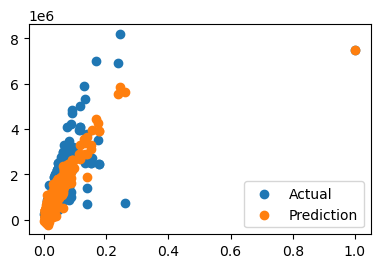



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.768414246943889
Residual Sum of Squares (RSS) on Training set  ---> 160202605054009.0
Mean Squared Error (MSE) on Training set       ---> 152719356581.51477
Root Mean Squared Error (RMSE) on Training set ---> 390793.24019424233

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -1.3016732676550516e+22
Residual Sum of Squares (RSS) on Training set  ---> 1.9946430197803048e+36
Mean Squared Error (MSE) on Training set       ---> 7.584193991560093e+33
Root Mean Squared Error (RMSE) on Training set ---> 8.708727801211893e+16

--------------------Residual Plots--------------------


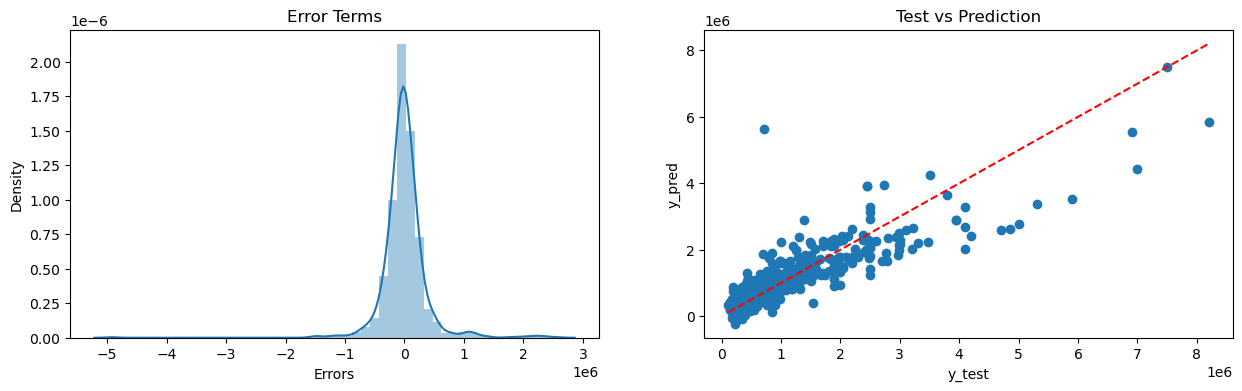

In [151]:
MLR = LinearRegression().fit(scaled_X_train,y_train)
pred1 = MLR.predict(scaled_X_train)
pred2 = MLR.predict(scaled_X_test)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

<h2 style="font-size: 25px; color: #5e6670;"><strong>6.2. Ridge Regression Model</strong></h2> 

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 1.86557146e+05 -4.02698058e+05  7.29648928e+04  1.13143886e+05
  2.08664563e+07  6.94309098e+05 -5.88185227e+03  6.42753469e+19
  1.72340478e+19  6.42549345e+19  1.46381287e+19  4.86313528e+19
 -4.40320000e+04 -1.89237873e+19 -2.58457853e+19 -5.54616557e+19
  5.52096406e+18 -1.19027402e+19  8.48515251e+18  2.91039483e+19
  1.64703637e+19  6.73343288e+18 -2.55573718e+19 -2.37017739e+18
 -1.10462580e+19  4.06732513e+18  1.35660241e+19 -2.24329796e+19
 -2.26854627e+19 -2.79033551e+19 -9.47166874e+18 -9.55215462e+18
 -1.39660836e+19  2.83393598e+19  5.12774188e+18  7.88757227e+18
  2.00088022e+19 -2.33889147e+17 -3.42468323e+19  2.49129412e+18
  7.26512652e+18 -7.93900415e+18 -2.78687297e+18 -3.51625491e+18
 -8.04153822e+18 -2.88405490e+18 -4.54784719e+17  1.13183456e+18
  1.43440004e+19  4.39598707e+19 -1.70227490e+19  4

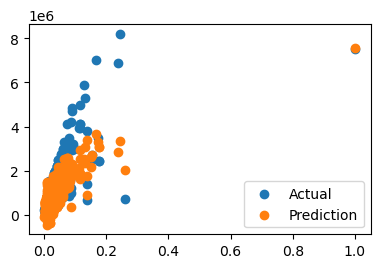



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.6594358416963196
Residual Sum of Squares (RSS) on Training set  ---> 235589904077805.47
Mean Squared Error (MSE) on Training set       ---> 224585227910.20544
Root Mean Squared Error (RMSE) on Training set ---> 473904.23917728924

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.6482418510813394
Residual Sum of Squares (RSS) on Training set  ---> 53902308192548.86
Mean Squared Error (MSE) on Training set       ---> 204951742176.99185
Root Mean Squared Error (RMSE) on Training set ---> 452715.96191982436

--------------------Residual Plots--------------------


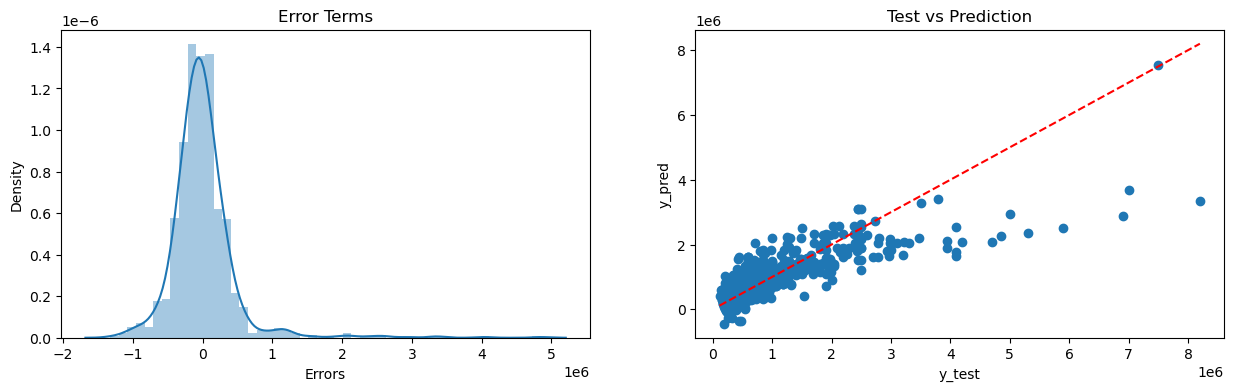

In [152]:
RLR = Ridge().fit(scaled_X_train,y_train)
pred1 = RLR.predict(scaled_X_train)
pred2 = RLR.predict(scaled_X_test)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

<h2 style="font-size: 25px; color: #5e6670;"><strong>6.3. Lasso</strong></h2> 

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 1.86557146e+05 -4.02698058e+05  7.29648928e+04  1.13143886e+05
  2.08664563e+07  6.94309098e+05 -5.88185227e+03  6.42753469e+19
  1.72340478e+19  6.42549345e+19  1.46381287e+19  4.86313528e+19
 -4.40320000e+04 -1.89237873e+19 -2.58457853e+19 -5.54616557e+19
  5.52096406e+18 -1.19027402e+19  8.48515251e+18  2.91039483e+19
  1.64703637e+19  6.73343288e+18 -2.55573718e+19 -2.37017739e+18
 -1.10462580e+19  4.06732513e+18  1.35660241e+19 -2.24329796e+19
 -2.26854627e+19 -2.79033551e+19 -9.47166874e+18 -9.55215462e+18
 -1.39660836e+19  2.83393598e+19  5.12774188e+18  7.88757227e+18
  2.00088022e+19 -2.33889147e+17 -3.42468323e+19  2.49129412e+18
  7.26512652e+18 -7.93900415e+18 -2.78687297e+18 -3.51625491e+18
 -8.04153822e+18 -2.88405490e+18 -4.54784719e+17  1.13183456e+18
  1.43440004e+19  4.39598707e+19 -1.70227490e+19  4

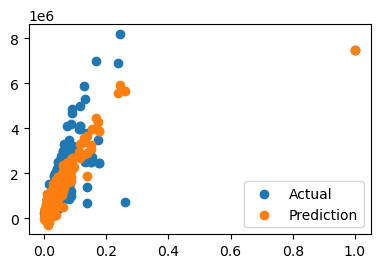



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.7692591465014575
Residual Sum of Squares (RSS) on Training set  ---> 159618134254984.25
Mean Squared Error (MSE) on Training set       ---> 152162187087.68756
Root Mean Squared Error (RMSE) on Training set ---> 390079.7188879313

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.6131503963852021
Residual Sum of Squares (RSS) on Training set  ---> 59279611921746.73
Mean Squared Error (MSE) on Training set       ---> 225397763961.01422
Root Mean Squared Error (RMSE) on Training set ---> 474760.74391319905

--------------------Residual Plots--------------------


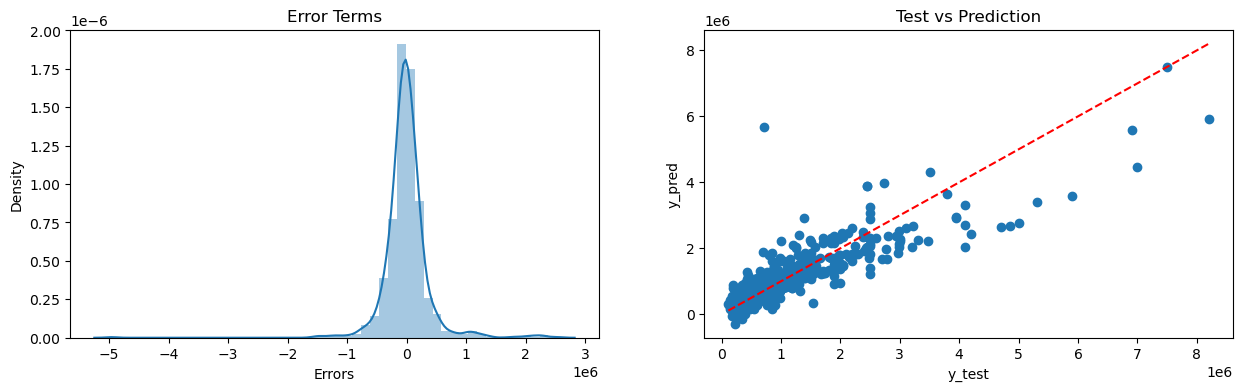

In [153]:
LLR = Lasso().fit(scaled_X_train,y_train)
pred1 = LLR.predict(scaled_X_train)
pred2 = LLR.predict(scaled_X_test)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

<h2 style="font-size: 25px; color: #5e6670;"><strong>6.4. Elastic-Net Regression</strong></h2> 

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 1.86557146e+05 -4.02698058e+05  7.29648928e+04  1.13143886e+05
  2.08664563e+07  6.94309098e+05 -5.88185227e+03  6.42753469e+19
  1.72340478e+19  6.42549345e+19  1.46381287e+19  4.86313528e+19
 -4.40320000e+04 -1.89237873e+19 -2.58457853e+19 -5.54616557e+19
  5.52096406e+18 -1.19027402e+19  8.48515251e+18  2.91039483e+19
  1.64703637e+19  6.73343288e+18 -2.55573718e+19 -2.37017739e+18
 -1.10462580e+19  4.06732513e+18  1.35660241e+19 -2.24329796e+19
 -2.26854627e+19 -2.79033551e+19 -9.47166874e+18 -9.55215462e+18
 -1.39660836e+19  2.83393598e+19  5.12774188e+18  7.88757227e+18
  2.00088022e+19 -2.33889147e+17 -3.42468323e+19  2.49129412e+18
  7.26512652e+18 -7.93900415e+18 -2.78687297e+18 -3.51625491e+18
 -8.04153822e+18 -2.88405490e+18 -4.54784719e+17  1.13183456e+18
  1.43440004e+19  4.39598707e+19 -1.70227490e

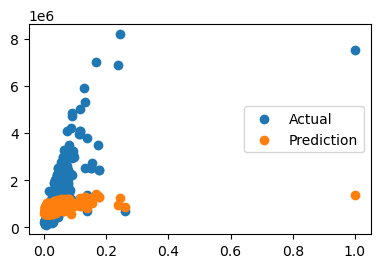



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.19207304398921862
Residual Sum of Squares (RSS) on Training set  ---> 558894497343810.5
Mean Squared Error (MSE) on Training set       ---> 532787890699.5333
Root Mean Squared Error (RMSE) on Training set ---> 729923.2087689316

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.198801219005054
Residual Sum of Squares (RSS) on Training set  ---> 122773171707445.86
Mean Squared Error (MSE) on Training set       ---> 466818143374.3189
Root Mean Squared Error (RMSE) on Training set ---> 683240.9116660967

--------------------Residual Plots--------------------


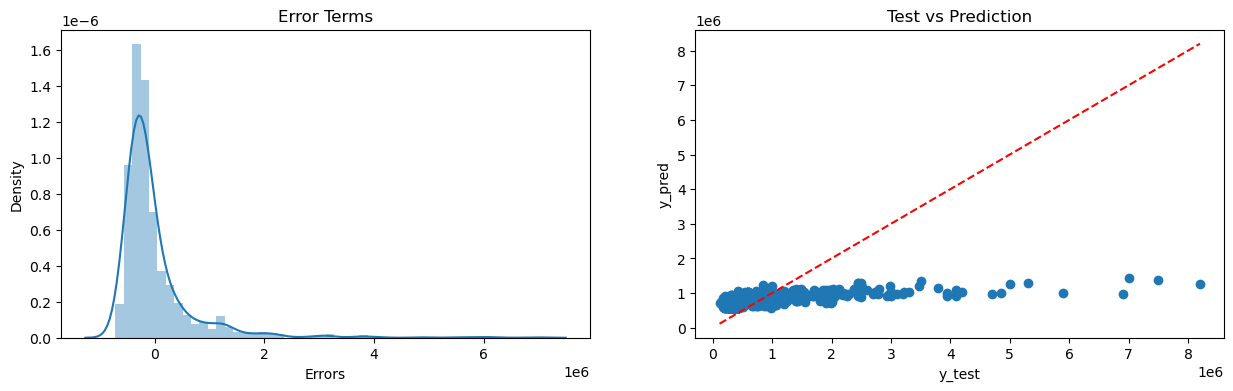

In [154]:
ENR = ElasticNet().fit(scaled_X_train,y_train)
pred1 = ENR.predict(scaled_X_train)
pred2 = ENR.predict(scaled_X_test)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

<h2 style="font-size: 25px; color: #5e6670;"><strong>6.6. Compare the Models</strong></h2> 

In [155]:
Model_Evaluation_Comparison_Matrix.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)']

In [156]:
Model_Evaluation_Comparison_Matrix

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.768414,-1.301673e+22,1.602026e+14,1.994643e+36,1.527194e+11,7.584194e+33,390793.240194,8.708728e+16
Ridge Linear Regression (RLR),0.659436,6.482419e-01,2.355899e+14,5.390231e+13,2.245852e+11,2.049517e+11,473904.239177,4.527160e+05
Lasso Linear Regression (LLR),0.769259,6.131504e-01,1.596181e+14,5.927961e+13,1.521622e+11,2.253978e+11,390079.718888,4.747607e+05
Elastic-Net Regression (ENR),0.192073,1.988012e-01,5.588945e+14,1.227732e+14,5.327879e+11,4.668181e+11,729923.208769,6.832409e+05


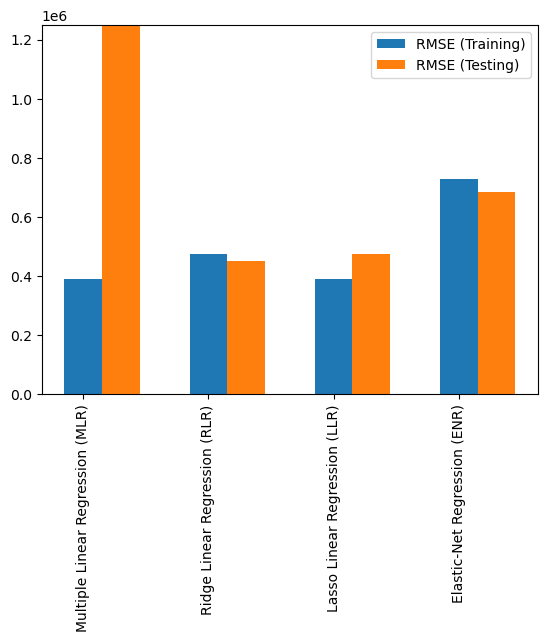

In [158]:
cc = Model_Evaluation_Comparison_Matrix.columns.values
s=4
plt.bar(np.arange(4), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(4)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(4),Model_Evaluation_Comparison_Matrix.index, rotation =90)
plt.legend()
plt.ylim([0,1.25e6])
plt.show()

# Agora so falta escolhermos o modelo a usar (diria que o RLR ou LLR) e fazermos um codigo para gerar featrures random e prever o preco